#ВЫПУСКНОЙ ПРОЕКТ

слушателя 7 потока курса "Аналитик данных" Бельского В.Р. (кейс №21)

Передо мной стояла задача на основе предоставленных данных сделать анализ продаж компании.

Этапы работы:
- Загрузка предоставленных данных в Google Colab, их изучение и консолидация.
- Предобработка и исследовательский анализ данных в Google Colab.
- Создание новых признаков в Google Colab  и выгрузка подготовленного файла в BigQuery.
- Проведение ABC, XYZ и RFM анализа загруженных из BigQuery подготовленных данных с помощью платформы Loginom и, параллельно, в Google Colab с использованием BigQuery.
- Проведение кластеризации покупателей с использованием платформы Loginom и, параллельно, в Google Colab.
- Исследование оттока клиентов на платформе Loginom и в Google Colab.
- Прогнозирование прибыли с помощью решения задачи прогнозирования временных рядов на платформе Loginom и в Google Colab помощью фреймворка Prophet.
- Анализ подготовленных данных с помощью Tableau.

In [1]:
# Подключение к  Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Предоставление доступа к аккаунту Google.
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


## Импорты необходимых библиотек

In [3]:
!pip install google-cloud-bigquery google-cloud-bigquery-storage --upgrade

In [4]:
pip install -U dataprep

In [5]:
# Импорт библиотек.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from google.cloud import bigquery
from dataprep.eda import create_report, plot, plot_correlation, plot_missing

pd.set_option('display.max_columns', None)

## Загрузка исходных файлов

In [6]:
# Загрузка файлов.
customer = pd.read_excel('/content/drive/MyDrive/Finance University/VP/Customer.xlsx')
product = pd.read_excel('/content/drive/MyDrive/Finance University/VP/Product.xlsx')
sales = pd.read_excel('/content/drive/MyDrive/Finance University/VP/Sales.xlsx')
territories = pd.read_excel('/content/drive/MyDrive/Finance University/VP/Territories.xlsx')

Загрузили четыре датасета из Google Drive.

In [7]:
# Название проекта в BigQuery.
BqProject='valiant-arcana-401308'

Выгружаем в DigQuery датасет customer.

In [8]:
# Название датасета и таблицы.
#BqDatasetwithtable='VP21.Customer'
# Выгрузка датасета в таблицу BigQuery.
#customer.to_gbq(BqDatasetwithtable, BqProject)

Выгружаем в DigQuery датасет product.

In [9]:
# Название датасета и таблицы.
#BqDatasetwithtable='VP21.Product'
# Выгрузка датасета в таблицу BigQuery.
#product.to_gbq(BqDatasetwithtable, BqProject)

Выгружаем в DigQuery датасет sales.

In [10]:
# Название датасета и таблицы.
#BqDatasetwithtable='VP21.Sales'
# Выгрузка датасета в таблицу BigQuery.
#sales.to_gbq(BqDatasetwithtable, BqProject)

Выгружаем в DigQuery датасет territories.

In [11]:
# Название датасета и таблицы.
#BqDatasetwithtable='VP21.Territories'
# Выгрузка датасета в таблицу BigQuery.
#territories.to_gbq(BqDatasetwithtable, BqProject)

Таблицы загружены в BigQuery.

## Предварительный анализ исходных данных

### Customer

In [12]:
# Общая информация о датасете.
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CustomerKey           18484 non-null  int64 
 1   FirstName             18484 non-null  object
 2   LastName              18484 non-null  object
 3   FullName              18484 non-null  object
 4   BirthDate             18484 non-null  object
 5   MaritalStatus         18484 non-null  object
 6   Gender                18484 non-null  object
 7   YearlyIncome          18484 non-null  int64 
 8   TotalChildren         18484 non-null  int64 
 9   NumberChildrenAtHome  18484 non-null  int64 
 10  Education             18484 non-null  object
 11  Occupation            18484 non-null  object
 12  HouseOwnerFlag        18484 non-null  int64 
 13  NumberCarsOwned       18484 non-null  int64 
 14  AddressLine1          18484 non-null  object
 15  DateFirstPurchase     18484 non-null

In [13]:
customer.head()

CustomerKey  FirstName LastName            FullName   BirthDate  \
0        11000        Jon     Yang           Yang, Jon  1966-04-08   
1        11001     Eugene    Huang       Huang, Eugene  1965-05-14   
2        11002      Ruben   Torres       Torres, Ruben  1965-08-12   
3        11003    Christy      Zhu        Zhu, Christy  1968-02-15   
4        11004  Elizabeth  Johnson  Johnson, Elizabeth  1968-08-08   

  MaritalStatus Gender  YearlyIncome  TotalChildren  NumberChildrenAtHome  \
0             M      M         90000              2                     0   
1             S      M         60000              3                     3   
2             M      M         60000              3                     3   
3             S      F         70000              0                     0   
4             S      F         80000              5                     5   

   Education    Occupation  HouseOwnerFlag  NumberCarsOwned  \
0  Bachelors  Professional               1                0   
1  Bachelors  Professional               0                1   
2  Bachelors  Professional               1                1   
3  Bachelors  Professional               0                1   
4  Bachelors  Professional               1                4   

          AddressLine1 DateFirstPurchase CommuteDistance CustomerCity  \
0      3761 N. 14th St        2005-07-22       1-2 Miles  Rockhampton   
1           2243 W St.        2005-07-18       0-1 Miles      Seaford   
2     5844 Linden Land        2005-07-10       2-5 Miles       Hobart   
3     1825 Village Pl.        2005-07-01      5-10 Miles   North Ryde   
4  7553 Harness Circle        2005-07-26       1-2 Miles   Wollongong   

  CustomerStateCode    CustomerState CustomerCountry  
0               QLD       Queensland       Australia  
1               VIC         Victoria       Australia  
2               TAS         Tasmania       Australia  
3               NSW  New South Wales       Australia  
4               NSW  New South Wales       Australia

В датасете 20 столбцов и 18484 строки. Столбцы CustomerKey, YearlyIncom, TotalChildren, NumberChildrenAtHome, HouseOwnerFlag и NumberCarsOwned имеют тип данных int. Остальные столбцы - object. Пропусков нет.

Датасет customer содержит информацию о покупателях:
- CustomerKey - уникальный идентификатор покупателя,
- FirstName - имя,
- LastName - фамилия,
- FullName - имя и фамилия,
- BirthDate - дата рождения,
- MaritalStatus - семейное положение,
- Gender - пол,
- YearlyIncome - годовой доход,
- TotalChildren - количество детей,
- NumberChildrenAtHome - количество детей дома,
- Education - образование,
- Occupation - род занятий,
- HouseOwnerFlag - наличие собственного дома,
- NumberCarsOwned - количество машин,
- AddressLine1 - адрес,
- DateFirstPurchase - дата первой покупки,
- CommuteDistance - дальность поездок,
- CustomerCity - страна проживания,
- CustomerStateCode код штата,
- CustomerState - штат проживания,
- CustomerCountry - страна проживания.

Столбцы FirstName и LastName дублируют информацию, содержащуюся в столбце FullName и их можно удалить.

Столбец CustomerStateCode дублирует информацию столбца CustomerState, но, возможно, он пригодится в дальнейшем.

Столбцы BirthDate и DateFirstPurchase содержат дату и их нужно привести к типу datetime.

In [14]:
# Удаление лишних столбцов.
customer = customer. drop(columns=['FirstName', 'LastName'])

In [15]:
# Приведение данных столбцов, содержащих дату, к типу datetime.
customer['BirthDate'] = pd.to_datetime(customer['BirthDate'])
customer['DateFirstPurchase'] = pd.to_datetime(customer['DateFirstPurchase'])

In [16]:
# Общая информация.
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   CustomerKey           18484 non-null  int64         
 1   FullName              18484 non-null  object        
 2   BirthDate             18484 non-null  datetime64[ns]
 3   MaritalStatus         18484 non-null  object        
 4   Gender                18484 non-null  object        
 5   YearlyIncome          18484 non-null  int64         
 6   TotalChildren         18484 non-null  int64         
 7   NumberChildrenAtHome  18484 non-null  int64         
 8   Education             18484 non-null  object        
 9   Occupation            18484 non-null  object        
 10  HouseOwnerFlag        18484 non-null  int64         
 11  NumberCarsOwned       18484 non-null  int64         
 12  AddressLine1          18484 non-null  object        
 13  DateFirstPurchas

В датасете осталось 19 столбцов.

In [17]:
# Количество дубликатов.
customer.duplicated().sum()

0

##### Распределения данных в столбцах

In [18]:
# Статистики по численным столбцам.
customer.describe()

CustomerKey   YearlyIncome  TotalChildren  NumberChildrenAtHome  \
count  18484.000000   18484.000000   18484.000000          18484.000000   
mean   20241.500000   57305.777970       1.844352              1.004058   
std     5336.015523   32285.841703       1.612408              1.522660   
min    11000.000000   10000.000000       0.000000              0.000000   
25%    15620.750000   30000.000000       0.000000              0.000000   
50%    20241.500000   60000.000000       2.000000              0.000000   
75%    24862.250000   70000.000000       3.000000              2.000000   
max    29483.000000  170000.000000       5.000000              5.000000   

       HouseOwnerFlag  NumberCarsOwned  
count    18484.000000     18484.000000  
mean         0.676369         1.502705  
std          0.467874         1.138394  
min          0.000000         0.000000  
25%          0.000000         1.000000  
50%          1.000000         2.000000  
75%          1.000000         2.000000  
max          1.000000         4.000000

Данные содержат значения годового дохода покупателей составляет от 10 до 170 тысяч. Медианное значение 60 тысяч (среднее - 57305).

68% покупателей имеют дом и больше 75% - один или более автомобиль. Больше половины покупателей имеют детей (максимальное количество - 5 детей), но количество детей в доме меньше. Возможно, дети уже выросли или семья распалась.

In [19]:
# Диаграмма размаха годового дохода покупателей в зависимости от их пола.
px.box(customer, x='YearlyIncome', y='Gender', title='Распределение годового дохода покупателей в зависимости от пола')

Распределение годового дохода не зависит от пола.

In [20]:
# Диаграмма размаха годового дохода покупателей в зависимости от их семейного положения.
px.box(customer, x='YearlyIncome', y='MaritalStatus', title='Распределение годового дохода покупателей в зависимости от их семейного положения')

Одинокие покупатели имеют годовой доход, как правило, ниже, чем женатые или замужние покупатели. Больше половины покупателей имеет доход от 30 до 80 тысяч. Немногие покупатели имеют годовой доход свыше 130 тысяч.

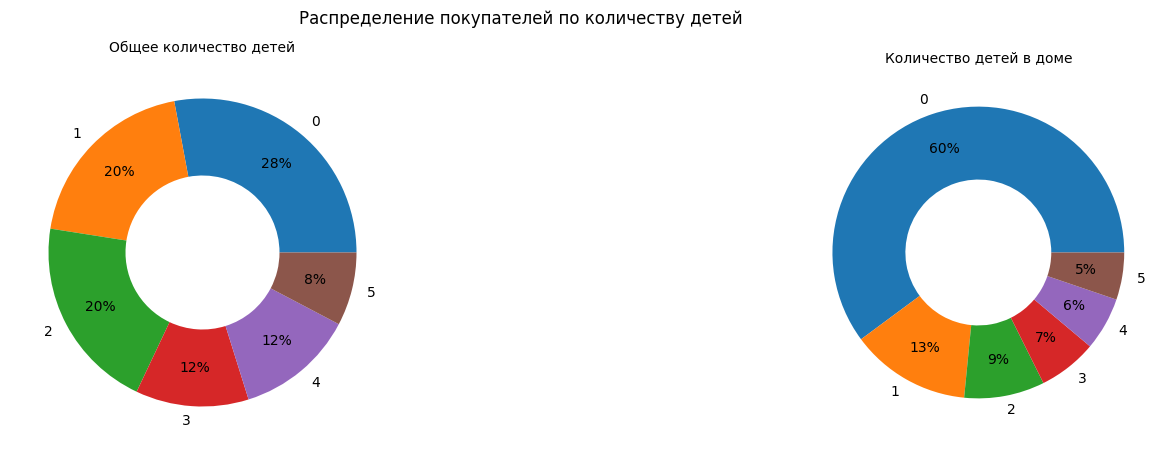

In [21]:
# Круговые диаграммы распределения покупателей по числу детей..
fig = plt.figure(figsize=(16,5))

plt.suptitle('Распределение покупателей по количеству детей', fontsize=12)

ax1 = fig.add_subplot(121)
ax1.pie(customer['TotalChildren'].value_counts().sort_index().values, wedgeprops=dict(width=0.5), pctdistance=0.75, labels=customer['TotalChildren'].value_counts().sort_index().index, autopct='%.0f%%')
ax1.set_title('Общее количество детей', fontsize=10)

ax2 = fig.add_subplot(133)
ax2.pie(customer['NumberChildrenAtHome'].value_counts().sort_index().values, wedgeprops=dict(width=0.5), pctdistance=0.75, labels=customer['NumberChildrenAtHome'].value_counts().sort_index().index, autopct='%.0f%%')
ax2.set_title('Количество детей в доме', fontsize=10)

plt.show()

In [22]:
# Гистограмма распределения покупателей по количеству детей (всего и дома).
px.histogram(customer[['TotalChildren', 'NumberChildrenAtHome']], barmode='group', text_auto=True,
             title='Распределение покупателей по количеству детей (всего и дома)')

Среди общего числа покупателей не имеют своих детей 28%. При этом в доме детей нет уже у 60% покупателей. Вероятно, дети выросли или при распаде семьи живут с другим родителем.

In [23]:
px.scatter(customer, x='TotalChildren', y='NumberChildrenAtHome', title='Зависимость количества детей дома от общего количества детей у покупателя')

Выходит, что в доме у покупателя есть не только его дети. Вероятно, люди живут в домах большими семьями, в которых есть бездетные мужчины и женщины, а также их племянники, племянницы, сестры, братья и т.п. вместе со своими родителями.

In [24]:
# Статистики по категориальным столбцам.
customer.describe(include='object')

FullName MaritalStatus Gender  Education    Occupation  \
count          18484         18484  18484      18484         18484   
unique         18400             2      2          5             5   
top     Pal, Mohamed             M      M  Bachelors  Professional   
freq               3         10011   9351       5356          5520   

             AddressLine1 CommuteDistance CustomerCity CustomerStateCode  \
count               18484           18484        18484             18484   
unique              12802               5          269                53   
top     Attaché de Presse       0-1 Miles       London                CA   
freq                   17            6310          420              4444   

       CustomerState CustomerCountry  
count          18484           18484  
unique            53               6  
top       California   United States  
freq            4444            7819

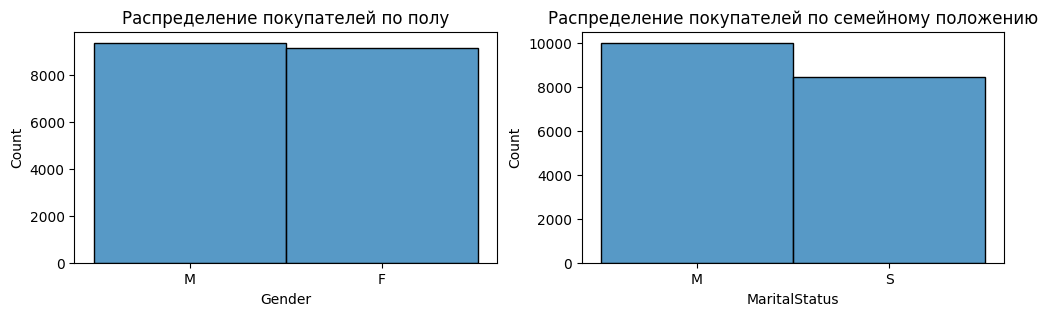

In [25]:
# Распределение покупателей по полу и семейному положению.
plt.figure(figsize=(12, 3))

plt.subplot(1,2,1)
sns.histplot(customer['Gender'])
plt.title('Распределение покупателей по полу')

plt.subplot(1,2,2)
sns.histplot(customer['MaritalStatus'])
plt.title('Распределение покупателей по семейному положению')

plt.show();

Мужчин и женщин среди покупателей примерно поровну. При этом состоящих в браке покупателей несколько больше, чем одиноких.

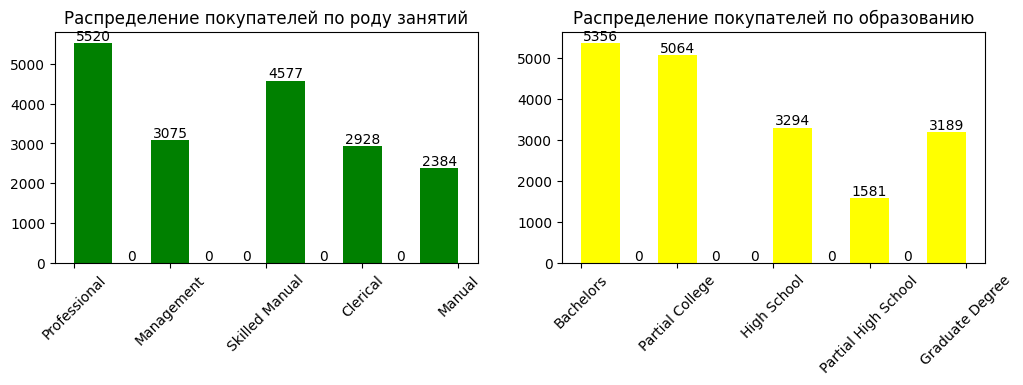

In [26]:
# Распределение покупателей по роду занятий и образованию.
plt.figure(figsize=(12, 3))

plt.subplot(1,2,1)
values, bins, bars = plt.hist(customer['Occupation'], color='green')
plt.xticks(rotation=45)
plt.bar_label(bars)
plt.title('Распределение покупателей по роду занятий')

plt.subplot(1,2,2)
values, bins, bars = plt.hist(customer['Education'], color='yellow')
plt.xticks(rotation=45)
plt.title('Распределение покупателей по образованию')
plt.bar_label(bars)
plt.show();

Среди покупателей по образованию в данных есть предствители с неоконченной старшей школой, старшей школой, неоконченным колледжем, бакалавриатом и магистратурой. Наиболее часто встречаются люди, имеющие степень бакалавра (5356) и частично закончившие колледж (5064). Меньше всего людей, не закончивших старшую школу (1581).

По роду занятий - рабочие, квалифицированные рабочие, офисные работники, профессионалы и руководители. Наиболее многочисленны группы профессионалов (5520) и квалифицированных рабочих (4577).

In [27]:
# Посмотрю уникальные значения в столбце CommuteDistance.
list(customer['CommuteDistance'].unique())

['1-2 Miles', '0-1 Miles', '2-5 Miles', '5-10 Miles', '10+ Miles']

Значения расстояния поездок разбиты на 5 диапазонов: до 1 мили, до 2 миль, до 5 миль, до 10 миль и свыше 10 миль.

In [28]:
# Гистограмма распределения покупателей по дальности поездок.
px.histogram(customer['CommuteDistance'], text_auto=True, title='Распределение покупателей по дальности поездок')

Больше всего покупателей совершают поездки на расстояяние до 1 мили (6310).

In [29]:
# Гистограмма распределения покупателей по странам.
px.histogram(customer['CustomerCountry'], text_auto=True, title='Распределение покупателей по странам')

In [30]:
# Гистограмма распределения покупателей по регионам.
px.histogram(customer['CustomerState'], text_auto=True, title='Распределение покупателей по регионам')

In [31]:
# Гистограмма распределения покупателей по городам.
px.histogram(customer['CustomerCity'], title='Распределение покупателей по городам')

Больше всего покупателей в США (7819). На втором месте Австралия (3591). В соединенном королевстве, Франции, Германии и Канаде - от 1.5 до 2 тысяч человек.

Среди штатов первое место занимает Калифорния (4444), на втором месте Вашингтон (2263), на третьем месте Англия (1913). В значительной части регионов количество покупателей не достигает 10 человек.

Среди городов можно выделить Лондон (420) и Париж (386).

<b>Вывод:</b>
- В исходном датафрейме Customer было 18484 строки и 21 столбец. Пропусков и дубликатов в данных нет.
- Были удалены столбцы, дублирующие информацию, FirstName и LastName.
- Столбцы BirthDate и DateFirstPurchase приведены к типу datetime.
- Покупатели равномерно распределены на мужчин и женщин с небольшим перевесом в сторону состоящих в браке.
- В количественных столбцах явных аномалий не наблюдается.
- Распределение годового дохода покупателей не зависит от пола.
- Одинокие покупатели имеют годовой доход, как правило, ниже, чем состоящие в браке.
- Больше половины покупателей имеет доход от 30 до 80 тысяч, и лишь немногие покупатели имеют годовой доход свыше 130 тысяч.
- Среди покупателей по образованию в данных есть предствители с неоконченной старшей школой, старшей школой, неоконченным колледжем, бакалавриатом и магистратурой. Наиболее часто встречаются люди, имеющие степень бакалавра (5356) и частично закончившие колледж (5064). Меньше всего людей, не закончивших старшую школу (1581).
- По роду занятий покупатели - рабочие, квалифицированные рабочие, офисные работники, профессионалы и руководители. Наиболее многочисленны группы профессионалов (5520) и квалифицированных рабочих (4577).
- Больше всего покупателей совершают поездки на расстояяние до 1 мили (6310).
- Больше всего покупателей в США (7819) и Австралии (3591). В соединенном королевстве, Франции, Германии и Канаде - от 1.5 до 2 тысяч человек.
- Среди регионов первое место занимает Калифорния (4444), на втором месте Вашингтон (2263), на третьем месте Англия (1913).
- В значительной части регионов количество покупателей не достигает 10 человек.
- Среди городов можно выделить Лондон (420) и Париж (386).

Датафрейм готов к объединению.

- Все товары разделены на 4 продуктовых линейки: дорожную, горную, туристическую и спортивную. Кроме этого есть самая многочисленная неопределенная продуктовая линейка.
- В дорожную и горную продуктовые линейки входят велосипеды, запчасти, аксессуары и одежда. В туристическую линейку входят только велосипеды, запчасти и аксессуары.
- В спортивную линейку входят аксессуары и одежда.

### Product

In [32]:
# Последние 5 строк.
product.tail()

ProductKey         ProductName      SubCategory    Category  \
601         602   ML Bottom Bracket  Bottom Brackets  Components   
602         603   HL Bottom Bracket  Bottom Brackets  Components   
603         604  Road-750 Black, 44       Road Bikes       Bikes   
604         605  Road-750 Black, 48       Road Bikes       Bikes   
605         606  Road-750 Black, 52       Road Bikes       Bikes   

     StandardCost  Color  ListPrice  DaysToManufacture ProductLine  \
601       44.9506    NaN     101.24                  1         NaN   
602       53.9416    NaN     121.49                  1         NaN   
603      343.6496  Black     539.99                  4        Road   
604      343.6496  Black     539.99                  4        Road   
605      343.6496  Black     539.99                  4        Road   

             ModelName                                              Photo  \
601  ML Bottom Bracket  http://www.avising.com/me/LearnPBI/DataSources...   
602  HL Bottom Bracket  http://www.avising.com/me/LearnPBI/DataSources...   
603           Road-750  http://www.avising.com/me/LearnPBI/DataSources...   
604           Road-750  http://www.avising.com/me/LearnPBI/DataSources...   
605           Road-750  http://www.avising.com/me/LearnPBI/DataSources...   

                                    ProductDescription  StartDate  
601       Aluminum alloy cups; large diameter spindle. 2007-07-01  
602             Aluminum alloy cups and a hollow axle. 2007-07-01  
603  Entry level adult bike; offers a comfortable r... 2007-07-01  
604  Entry level adult bike; offers a comfortable r... 2007-07-01  
605  Entry level adult bike; offers a comfortable r... 2007-07-01

In [33]:
# Общая информация о датасете.
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606 entries, 0 to 605
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ProductKey          606 non-null    int64         
 1   ProductName         606 non-null    object        
 2   SubCategory         397 non-null    object        
 3   Category            397 non-null    object        
 4   StandardCost        395 non-null    float64       
 5   Color               352 non-null    object        
 6   ListPrice           395 non-null    float64       
 7   DaysToManufacture   606 non-null    int64         
 8   ProductLine         380 non-null    object        
 9   ModelName           397 non-null    object        
 10  Photo               606 non-null    object        
 11  ProductDescription  396 non-null    object        
 12  StartDate           606 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object

В датафрейме 13 столбцов и 606 строк. Два столбца Photo и ProductDescription содержат информацию (ссылка на фото и описание товара), которая в данном исследовании не понадобится. Столбец StartDate соделжит дату и имеет тип datetime. Все остальные данные в столбцах имеют тип данных, соответствующий содержанию.

В столбцах SubCategory, Category, StandardCost, Color, ListPrice, ProductLine и ModelName есть пропуски.

In [34]:
# Удаление ненужных столбцов.
product = product.drop(columns=['Photo', 'ProductDescription'])

In [35]:
# Количество пропусков в столбцах.
product.isna().sum()

ProductKey             0
ProductName            0
SubCategory          209
Category             209
StandardCost         211
Color                254
ListPrice            211
DaysToManufacture      0
ProductLine          226
ModelName            209
StartDate              0
dtype: int64

In [36]:
# Первые 5 строк с пропусками.
product[product['Category'].isna()].head()

ProductKey            ProductName SubCategory Category  StandardCost Color  \
0           1        Adjustable Race         NaN      NaN           NaN   NaN   
1           2           Bearing Ball         NaN      NaN           NaN   NaN   
2           3        BB Ball Bearing         NaN      NaN           NaN   NaN   
3           4  Headset Ball Bearings         NaN      NaN           NaN   NaN   
4           5                  Blade         NaN      NaN           NaN   NaN   

   ListPrice  DaysToManufacture ProductLine ModelName  StartDate  
0        NaN                  0         NaN       NaN 1998-06-01  
1        NaN                  0         NaN       NaN 1998-06-01  
2        NaN                  1         NaN       NaN 1998-06-01  
3        NaN                  0         NaN       NaN 1998-06-01  
4        NaN                  1         NaN       NaN 1998-06-01

Создается впечатление, что  во всех столбцах пропуски находятся в одних и тех же строках.

In [37]:
# Пропуски в столбцах, за исключением строк с пропускоами в столбце Category.
product[product['Category'].notna()].isna().sum()

ProductKey            0
ProductName           0
SubCategory           0
Category              0
StandardCost          2
Color                56
ListPrice             2
DaysToManufacture     0
ProductLine          17
ModelName             0
StartDate             0
dtype: int64

Предположение о том, что пропуски находятся в одних и техже строках подтвердилось. Кроме них есть небольшое количество пропусков в столбцах Color, ListPrice и ProductLine.

In [38]:
# Сама поздняя дата начала продаж товаров с пропущенными значениями.
product.loc[product['Category'].isna(), 'StartDate'].max()

Timestamp('1998-06-01 00:00:00')

Пропущенные значения в основном находятся в одних и тех же строках. И эти строки содержат информацию о товарах, продажи которых начались ранее 01.06.1998 года.

В остальных строках имеются 17 товаров с незаполненной продуктоваой линейкой, 2 товара с незаполненным цветом и 56 товаров с незаполненным цветом.

In [39]:
# Заполню пропущенные значения на 'unknown'.
product = product.fillna('unknown')

In [40]:
# Заменю в столбцах StandardCost и ListPrice, содержащих численные значения, 'unknown' на 0.
product['StandardCost'] = product['StandardCost'].replace('unknown', 0).astype('float')
product['ListPrice'] = product['ListPrice'].replace('unknown', 0).astype('float')

In [41]:
# Количество дубликатов.
product.duplicated().sum()

0

In [42]:
# Общая информация о датасете.
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606 entries, 0 to 605
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ProductKey         606 non-null    int64         
 1   ProductName        606 non-null    object        
 2   SubCategory        606 non-null    object        
 3   Category           606 non-null    object        
 4   StandardCost       606 non-null    float64       
 5   Color              606 non-null    object        
 6   ListPrice          606 non-null    float64       
 7   DaysToManufacture  606 non-null    int64         
 8   ProductLine        606 non-null    object        
 9   ModelName          606 non-null    object        
 10  StartDate          606 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 52.2+ KB


В датафрейме осталось 11 столбцов, содержащих информацию о товарах:
- ProductKey - уникальный номер товара,
- ProductName - название товара,
- Category - категория товара,
- SubCategory - подкатегория товара,
- StandardCost - стандартная стоимость товара,
- Color - цвет товара,
- ListPrice - цена продажи в прайс-листе,
- DaysToManufacture - количество дней, необходимых для изготовления товара,
- ProductLine - продуктовая линейка,
- ModelName - название модели,
- StartDate - дата начала продаж товара.


In [43]:
# Статистики по численным столбцам.
product.describe()

ProductKey  StandardCost    ListPrice  DaysToManufacture
count   606.00000    606.000000   606.000000         606.000000
mean    303.50000    283.061060   487.337287           1.201320
std     175.08141    451.640333   764.969447           1.508893
min       1.00000      0.000000     0.000000           0.000000
25%     152.25000      0.000000     0.000000           0.000000
50%     303.50000     31.724400    62.005000           1.000000
75%     454.75000    418.120375   731.537050           1.000000
max     606.00000   2171.294200  3578.270000           4.000000

In [44]:
# Диаграммы размаха стоимости и цены товаров.
fig = go.Figure()
fig.add_trace(go.Box(x=product['StandardCost'], name='StandardCost'))
fig.add_trace(go.Box(x=product['ListPrice'], name='ListPrice'))
fig.update_layout(title='Распределение товаров по стоимости и цене')
fig.show()

In [45]:
# Распределение товаров по стоимости и цене.
fig = go.Figure()
fig.add_trace(go.Histogram(x=product['StandardCost'], name='StandardCost'))
fig.add_trace(go.Histogram(x=product['ListPrice'], name='ListPrice'))
fig.update_layout(title='Распределение товаров по стоимости и цене')
fig.show()

- Распределение цены товаров смещено относительно распределения стоимости товаров в сторону больших значений.
- 75% товаров имеют стоимость ниже 420$.

- А цену товара - ниже 743$.

- Нулевые значения стоимости и цены товаров были получены при заполнении пропусков.
- Больше всего товаров имеет стоимость и цену до 50$.

In [46]:
# Диаграмма размаха срока изготовления товаров.
px.box(product, x='DaysToManufacture', title='Распределение товаров по сроку изготовления')

In [47]:
# Гистограмма распределения товаров по сроку изготовления.
px.histogram(product['DaysToManufacture'], text_auto=True, title='Распределение товаров по сроку изготовления')

Подавляющее количество наименований товаров имется на складе (265) и времени на изготовления не требует или можно изготовить за 1 день (204).

На изготовление 125 наименований требуется 4 дня.

In [48]:
# Статистики по категориальным столбцам.
product.describe(include='object')

ProductName SubCategory Category    Color  \
count                              606         606      606      606   
unique                             504          38        5       10   
top     HL Mountain Frame - Silver, 38     unknown  unknown  unknown   
freq                                 3         209      209      254   

       ProductLine ModelName  
count          606       606  
unique           5       120  
top        unknown   unknown  
freq           226       209

В данных представлено 504 уникальных названий товаров 10 цветов из 5 категорий (38 подкатегорий) и 5 продуктовых линеек (120 названий моделей).

In [49]:
# Гистограмма распределения товаров по категориям и подкатегориям.
px.histogram(product, x='Category', color='SubCategory', text_auto=True, title='Распределение товаров по категориям и подкатегориям')

- Все товары разделены на 5 категорий: велосипеды, запчасти, аксессуары, одежда и часть товаров с пропущенными значениями, которая была названа unknown.
- В категории велосипеды есть три подкатегории: дорожные велосипеды (65), горные велосипеды (38) и туристические велосипеды (22).
- В категории запчасти из большого количества наименований можно выделить рамы для дорожных велосипедов (70), рамы для горных велосипедов (40), рамы для туристских велосипедов (18), колеса (14) и рули (14).
- Из аксессуаров больше всего наименований у шлемов (6) и шин/камер (11).
- Среди одежды количеством наименований выделяются трикотажные изделия (16), перчатки (9) и шорты (7).
- С неопределенной категорией 209 наименований товаров.

In [50]:
# Гистограмма распределения товаров по продуктовым линейкам и категориям.
px.histogram(product, x='ProductLine', color='Category', text_auto=True, title='Распределение товаров по продуктовым линейкам и категориям')

In [51]:
# Распределение наименований товаротоваров по  моделей по продуктовым линейкам.
product_group = product.groupby('ProductLine')['ModelName'].count()
px.bar(x=product_group.index, y=product_group.values, text_auto=True, labels = dict(y='Count'), title='Распределение моделей по продуктовым линейкам')

В дорожной продуктовой линейке 162 модели, в горной - 112 модели, в туристической 52 модели и в спортивной 54 модели.

<b>Вывод:</b>

Датафрейм product содержит справочник товаров.

- В исходном датафрейме 606 строк и 13 столбцов.
- Два столбца Photo и ProductDescription содержали информацию (ссылка на фото и описание товара), которая в данном исследовании не понадобится. Эти столбцы были удалены.
- Столбец StartDate содержит дату и имеет тип datetime. Все остальные данные в столбцах имеют тип данных, соответствующий содержанию.
- В столбцах SubCategory, Category, StandardCost, Color, ListPrice, ProductLine и ModelName были обнаружены пропуски.
- Пропущенные значения в основном находятся в одних и тех же строках. И эти строки содержат информацию о товарах, продажи которых начались ранее 01.06.1998 года. В остальных строках имеются 17 товаров с незаполненной продуктоваой линейкой и 56 товаров с незаполненным цветом. Пропуски в категориальных столбцах были заменены на значение 'unknown', а численных столбцах StandardCost и ListPrice на 0.
- Дубликатов в данных нет.

Распределение товаров по цене:
- Распределение цены товаров смещено относительно распределения стоимости товаров в сторону больших значений.
- 75% товаров имеют стоимость ниже 420$.

- А цену товара - ниже 743$.

- Нулевые значения стоимости и цены товаров были получены при заполнении пропусков.
- Больше всего товаров имеет стоимость и цену до 50$.

Распределение товаров по времени изготовления:
- Подавляющее количество наименований товаров имется на складе (265) и времени на изготовления не требует или можно изготовить за 1 день (204). На изготовление 125 наименований требуется 4 дня.

Распределение товаров по категориям и подкатегориям:
- В данных представлено 504 уникальных названий товаров 10 цветов из 5 категорий (38 подкатегорий), 5 продуктовых линеек и 120 названий моделей.
- Все товары разделены на 5 категорий: велосипеды, запчасти, аксессуары, одежда и часть товаров с пропущенными значениями, которая была названа unknown.
- В категории велосипеды есть три подкатегории: дорожные велосипеды (65), горные велосипеды (38) и туристические велосипеды (22).
- В категории запчасти из большого количества наименований можно выделить рамы для дорожных велосипедов (70), рамы для горных велосипедов (40), рамы для туристских велосипедов (18), колеса (14) и рули (14).
- Из аксессуаров больше всего наименований у шлемов (6) и шин/камер (11).
- Среди одежды количеством наименований выделяются трикотажные изделия (16), перчатки (9) и шорты (7).
- С неопределенной категорией 209 наименований товаров.

Распределение товаров по продуктовым линейкам:
- Все товары разделены на 4 продуктовых линейки: дорожную, горную, туристическую и спортивную. Кроме этого есть самая многочисленная неопределенная продуктовая линейка.
- В дорожную и горную продуктовые линейки входят велосипеды, запчасти, аксессуары и одежда. В туристическую линейку входят только велосипеды, запчасти и аксессуары.
- В спортивную линейку входят аксессуары и одежда.
- В дорожной продуктовой линейке 162 модели, в горной - 112 модели, в туристической 52 модели и в спортивной 54 модели.


Датафрейм готов к объединению.




- В датафрейме 11 строк и 6 столбцов. В последней строке все нужные значения прпущены. Ее нужно удалить.
- Столбцы RegionImage и RegionInfo содержат информацию, которая в этом исследовании использоваться не будет. Их нужно удалить.

### Territories

In [52]:
# Общая информация.
territories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   SalesTerritoryKey  11 non-null     int64 
 1   Region             10 non-null     object
 2   Country            10 non-null     object
 3   Group              10 non-null     object
 4   RegionImage        11 non-null     object
 5   Region Info        10 non-null     object
dtypes: int64(1), object(5)
memory usage: 656.0+ bytes


In [53]:
# В датафрейме всего 11 строк.
territories

SalesTerritoryKey          Region         Country          Group  \
0                   1       Northwest   United States  North America   
1                   2       Northeast   United States  North America   
2                   3         Central   United States  North America   
3                   4       Southwest   United States  North America   
4                   5       Southeast   United States  North America   
5                   6          Canada          Canada  North America   
6                   7          France          France         Europe   
7                   8         Germany         Germany         Europe   
8                   9       Australia       Australia        Pacific   
9                  10  United Kingdom  United Kingdom         Europe   
10                 11             NaN             NaN            NaN   

                                          RegionImage  \
0   http://www.avising.com/me/LearnPBI/DataSources...   
1   http://www.avising.com/me/LearnPBI/DataSources...   
2   http://www.avising.com/me/LearnPBI/DataSources...   
3   http://www.avising.com/me/LearnPBI/DataSources...   
4   http://www.avising.com/me/LearnPBI/DataSources...   
5   http://www.avising.com/me/LearnPBI/DataSources...   
6   http://www.avising.com/me/LearnPBI/DataSources...   
7   http://www.avising.com/me/LearnPBI/DataSources...   
8   http://www.avising.com/me/LearnPBI/DataSources...   
9   http://www.avising.com/me/LearnPBI/DataSources...   
10  http://www.avising.com/me/LearnPBI/DataSources...   

                                          Region Info  
0   https://en.wikipedia.org/wiki/Northwestern_Uni...  
1   https://en.wikipedia.org/wiki/Northeastern_Uni...  
2   https://en.wikipedia.org/wiki/Central_United_S...  
3   https://en.wikipedia.org/wiki/Southwestern_Uni...  
4   https://en.wikipedia.org/wiki/Southeastern_Uni...  
5                https://en.wikipedia.org/wiki/Canada  
6                https://en.wikipedia.org/wiki/France  
7               https://en.wikipedia.org/wiki/Germany  
8             https://en.wikipedia.org/wiki/Australia  
9        https://en.wikipedia.org/wiki/United_Kingdom  
10                                                NaN

In [54]:
territories = territories.drop(columns=['RegionImage', 'Region Info'])
territories = territories.drop(index=10)
territories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   SalesTerritoryKey  10 non-null     int64 
 1   Region             10 non-null     object
 2   Country            10 non-null     object
 3   Group              10 non-null     object
dtypes: int64(1), object(3)
memory usage: 448.0+ bytes


- В датафрейме territories содержится информация о регионах продаж.
- Исходный датафрейм содержал 11 строк и 6 столбцов.
- Последняя стррока содержала пропуски в необходимых столбцах и была удалена.
- Информация в столбцах RegionImage и RegionInfo содержали информацию, которая в этом исследовании использоваться не будет. Эти столбцы также были удалены.
- В итоговом датафрейме 4 столбца и 10 строк. Дубликатов в датафрейме нет.

Столбцы датафрейма:
- SalesTerritoryKey - уникальный код территории,
- Region - регион,
- Country - страна,
- Group - часть света.

Датафрейм готов к объединению.

Категориальный столбец в датафрейме только один - номер заказа. 58189 транзакций содержится в 26683 заказах. Наибольшее число транзакций в одном заказе - 8.

### Sales

In [55]:
# Общая информация.
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58189 entries, 0 to 58188
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ProductKey            58189 non-null  int64         
 1   OrderDate             58189 non-null  datetime64[ns]
 2   ShipDate              58189 non-null  datetime64[ns]
 3   CustomerKey           58189 non-null  int64         
 4   PromotionKey          58189 non-null  int64         
 5   SalesTerritoryKey     58189 non-null  int64         
 6   SalesOrderNumber      58189 non-null  object        
 7   SalesOrderLineNumber  58189 non-null  int64         
 8   OrderQuantity         58189 non-null  int64         
 9   UnitPrice             58189 non-null  float64       
 10  TotalProductCost      58189 non-null  float64       
 11  SalesAmount           58189 non-null  float64       
 12  TaxAmt                58189 non-null  float64       
dtypes: datetime64[ns

In [56]:
# Первые 5 строк.
sales.head()

ProductKey  OrderDate   ShipDate  CustomerKey  PromotionKey  \
0         310 2014-01-01 2014-01-08        21768             1   
1         346 2014-01-01 2014-01-08        28389             1   
2         346 2014-01-01 2014-01-08        25863             1   
3         336 2014-01-01 2014-01-08        14501             1   
4         346 2014-01-01 2014-01-08        11003             1   

   SalesTerritoryKey SalesOrderNumber  SalesOrderLineNumber  OrderQuantity  \
0                  6          SO43697                     1              2   
1                  7          SO43698                     1              2   
2                  1          SO43699                     1              2   
3                  4          SO43700                     1              2   
4                  9          SO43701                     1              2   

   UnitPrice  TotalProductCost  SalesAmount    TaxAmt  
0  1789.1350         2171.2942    3578.2700  286.2616  
1  1699.9950         1912.1544    3399.9900  271.9992  
2  1699.9950         1912.1544    3399.9900  271.9992  
3   349.5491          413.1463     699.0982   55.9279  
4  1699.9950         1912.1544    3399.9900  271.9992

В датафрейме 58188 строк и 13 столбцов. Пропусков нет. В датафрейме содержатся транззакции с продажами товаров покупателям.

Типы данных в столбцах соответствуют содержащейся в них информации ( в том числе, в столбцах OrderDate и ShipDate, содержащих информацию о датах).

Назначения столбцов:
- ProductKey - уникальный код товара,
- OrderDate - дата заказа,
- ShipDate - дата отгрузки,
- CustomerKey - уникальный код покупателя,
- PromotionKey - промокод,
- SalesTerritoryKey - уникальный код территории,
- SalesOrderNumber - номер заказа,
- SalesOrderLineNumber - номер строки заказа,
- OrderQuantity - количество,
- UnitPrice - цена единицы товара,
- TotalProductCost - общая стоимость товара,
- SalesAmount - сумма заказа,
- TaxAmt - размер налога.

In [57]:
# Наличие дубликатов.
sales.duplicated().sum()

0

Дубликатов в датафрейме нет.

In [58]:
# Статистики чословых столбцов.
sales.describe()

ProductKey   CustomerKey  PromotionKey  SalesTerritoryKey  \
count  58189.000000  58189.000000  58189.000000       58189.000000   
mean     437.208304  18853.004640      1.043427           6.261716   
std      118.099746   5433.374315      0.348948           2.960248   
min      214.000000  11000.000000      1.000000           1.000000   
25%      358.000000  14012.000000      1.000000           4.000000   
50%      479.000000  18151.000000      1.000000           7.000000   
75%      529.000000  23450.000000      1.000000           9.000000   
max      606.000000  29483.000000     14.000000          10.000000   

       SalesOrderLineNumber  OrderQuantity     UnitPrice  TotalProductCost  \
count          58189.000000   58189.000000  58189.000000      58189.000000   
mean               1.887453       1.569386    413.888218        296.539185   
std                1.018829       1.047532    833.052938        560.171436   
min                1.000000       1.000000      0.572500          0.856500   
25%                1.000000       1.000000      4.990000          3.362300   
50%                2.000000       1.000000     24.490000         12.192400   
75%                2.000000       2.000000    269.995000        343.649600   
max                8.000000       4.000000   3578.270000       2171.294200   

        SalesAmount        TaxAmt  
count  58189.000000  58189.000000  
mean     503.666270     40.293303  
std      941.462817     75.317027  
min        2.290000      0.183200  
25%        8.990000      0.719200  
50%       32.600000      2.608000  
75%      539.990000     43.199200  
max     3578.270000    286.261600

- Минимальное значение промокода 1, максимальное 14. Подавляющее большинтво продаж осуществлялось  с промокодом 1. Вероятно значение 1 соответствует продажам без скидки.
- Количество товара в заказах меняется от 1 до 4. Более половины заказов содержит одну единицу товара.
- Цена единицы товара находится в диапазоне от 0.5727 до 3278.27 долларов.
- Сумма заказа меняется в диапазоне от 2.29 до 3578.27 долларов.
- Себестоимость заказа находится в диапазоне от 0.8565 до 2171.2942 долларов.

In [59]:
# Гистограмма распределения транзакций по промокодам.
px.histogram(sales['PromotionKey'], text_auto=True, title='Распределение транзакций по промокодам')

Подавляющее большинство (56038 из 58189) транзакций были проведены с промокодом 1. И лишь небольшое количесство: 2118 - спромокодом 2, 20 - с промокодом 13 и 13 - с промокодом 14.

In [60]:
# Гистограмма распределения транзакций по количеству товара в заказе.
px.histogram(sales['OrderQuantity'], text_auto=True, title='Распределение транзакций по по количеству товара в заказе')

Более 80% транзакций содержат одну штуку товара.

In [61]:
# Распределение транзакций по сумме и стоимости.
fig = go.Figure()
fig.add_trace(go.Box(x=sales['SalesAmount'], name='SalesAmount'))
fig.add_trace(go.Box(x=sales['TotalProductCost'], name='TotalProductCost'))
fig.update_layout(title='Распределение транзакций по сумме и стоимости')
fig.show()

In [62]:
# Распределение транзакций по сумме и стоимости.
fig = go.Figure()
fig.add_trace(go.Histogram(x=sales['SalesAmount'], name='SalesAmount'))
fig.add_trace(go.Histogram(x=sales['TotalProductCost'], name='TotalProductCost'))
fig.update_layout(title='Распределение транзакций по сумме и стоимости')
fig.show()

- Распределения транзакций по сумме заказов смещено относительно распределения стоимости заказов в большую сторону, что соответствует продажам с наценкой.
- Значительная часть транзакций находятся в области до 80 долларов.
- При этом, самая большая сумма заказа в транзакции составила 3528 долларов.

In [63]:
# Связь налога с суммой заказа.
list((sales['TaxAmt'] / sales['SalesAmount']).unique())

[0.08,
 0.08000006293822527,
 0.0800000214728606,
 0.08000001544834277,
 0.07999999999999999,
 0.08000000000000002]

Налог, с учетом погрешности округления, во всех транзакциях составляет 8% от суммы заказа.

In [64]:
# Статистики для категориальных столбцов.
sales.describe(include='object')

SalesOrderNumber
count             58189
unique            26683
top             SO58845
freq                  8

<b>Вывод:</b>

В датафрейме содержатся транзакции с продажами товаров покупателям.

- В датафрейме содержится 58188 строк и 13 столбцов. Пропусков и дубликатов нет.
- Типы данных в столбцах соответствуют содержащейся в них информации (в том числе, в столбцах OrderDate и ShipDate, содержащих информацию о датах).
- Минимальное значение в столбце с промокодом 1, максимальное 14. Подавляющее большинтво продаж осуществлялось  с промокодом 1. Вероятно, значение 1 соответствует продажам без скидки. И лишь небольшое количесство: 2118 - спромокодом 2, 20 - с промокодом 13 и 13 - с промокодом 14.
- Количество товара в заказах меняется от 1 до 4. Более половины транзакций содержит одну единицу товара.
- Цена единицы товара находится в диапазоне от 0.5727 до 3278.27 долларов.
- Сумма заказа меняется в диапазоне от 2.29 до 3578.27 долларов.
- Себестоимость заказа находится в диапазоне от 0.8565 до 2171.2942 долларов.
- Распределения транзакций по сумме заказов смещено относительно распределения стоимости заказов в большую сторону, что соответствует продажам с наценкой.
- Значительная часть транзакций находятся в области до 80 долларов.
- При этом, самая большая сумма заказа в транзакции составила 3528 долларов.
- Налог, с учетом погрешности округления, во всех транзакциях составляет 8% от суммы заказа.
- Категориальный столбец в датафрейме только один - номер заказа. 58189 транзакций содержится в 26683 заказах. Наибольшее число транзакций в одном заказе - 8.

Датафрейм готов к объединению.

## Объединение датафреймов.

#### Объединение датафреймов

Объединение четырех датафреймов буду проводить последовательно в три этапа. Основной датафрейм sales содержит информацию о транцакциях продажи товаров покупателю. В нем больше всего строк. Остальные датафреймы представляют собой справочники покупателе, товаров и территорий. Они будут последовательно присоединяться к основному датафрейму по схеме звезда.

In [65]:
# Первое объединение.
df = sales.merge(territories, how='left', left_on='SalesTerritoryKey', right_on='SalesTerritoryKey')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58189 entries, 0 to 58188
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ProductKey            58189 non-null  int64         
 1   OrderDate             58189 non-null  datetime64[ns]
 2   ShipDate              58189 non-null  datetime64[ns]
 3   CustomerKey           58189 non-null  int64         
 4   PromotionKey          58189 non-null  int64         
 5   SalesTerritoryKey     58189 non-null  int64         
 6   SalesOrderNumber      58189 non-null  object        
 7   SalesOrderLineNumber  58189 non-null  int64         
 8   OrderQuantity         58189 non-null  int64         
 9   UnitPrice             58189 non-null  float64       
 10  TotalProductCost      58189 non-null  float64       
 11  SalesAmount           58189 non-null  float64       
 12  TaxAmt                58189 non-null  float64       
 13  Region          

In [66]:
# Второе объединение.
df = df.merge(customer, how='left', left_on=['CustomerKey', 'Country'], right_on=['CustomerKey', 'CustomerCountry'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58189 entries, 0 to 58188
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ProductKey            58189 non-null  int64         
 1   OrderDate             58189 non-null  datetime64[ns]
 2   ShipDate              58189 non-null  datetime64[ns]
 3   CustomerKey           58189 non-null  int64         
 4   PromotionKey          58189 non-null  int64         
 5   SalesTerritoryKey     58189 non-null  int64         
 6   SalesOrderNumber      58189 non-null  object        
 7   SalesOrderLineNumber  58189 non-null  int64         
 8   OrderQuantity         58189 non-null  int64         
 9   UnitPrice             58189 non-null  float64       
 10  TotalProductCost      58189 non-null  float64       
 11  SalesAmount           58189 non-null  float64       
 12  TaxAmt                58189 non-null  float64       
 13  Region          

In [67]:
# Третье объединение.
df = df.merge(product, how='left', left_on='ProductKey', right_on='ProductKey')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58189 entries, 0 to 58188
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ProductKey            58189 non-null  int64         
 1   OrderDate             58189 non-null  datetime64[ns]
 2   ShipDate              58189 non-null  datetime64[ns]
 3   CustomerKey           58189 non-null  int64         
 4   PromotionKey          58189 non-null  int64         
 5   SalesTerritoryKey     58189 non-null  int64         
 6   SalesOrderNumber      58189 non-null  object        
 7   SalesOrderLineNumber  58189 non-null  int64         
 8   OrderQuantity         58189 non-null  int64         
 9   UnitPrice             58189 non-null  float64       
 10  TotalProductCost      58189 non-null  float64       
 11  SalesAmount           58189 non-null  float64       
 12  TaxAmt                58189 non-null  float64       
 13  Region          

Датафреймы объединены. Количество строк не изменилось. Пропуски не появились. Можно удалить лишние столбцы SalesTerritoryKey, SalesOrderLineNumber, CustomerStateCode, CustomerCountry.

In [68]:
df = df.drop(columns=['SalesTerritoryKey', 'SalesOrderLineNumber', 'CustomerStateCode', 'CustomerCountry'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58189 entries, 0 to 58188
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ProductKey            58189 non-null  int64         
 1   OrderDate             58189 non-null  datetime64[ns]
 2   ShipDate              58189 non-null  datetime64[ns]
 3   CustomerKey           58189 non-null  int64         
 4   PromotionKey          58189 non-null  int64         
 5   SalesOrderNumber      58189 non-null  object        
 6   OrderQuantity         58189 non-null  int64         
 7   UnitPrice             58189 non-null  float64       
 8   TotalProductCost      58189 non-null  float64       
 9   SalesAmount           58189 non-null  float64       
 10  TaxAmt                58189 non-null  float64       
 11  Region                58189 non-null  object        
 12  Country               58189 non-null  object        
 13  Group           

In [69]:
# Изменение названия столбцов CustomerCity на City и CustomerState на Stste.
df = df.rename(columns={'CustomerCity':'City', 'CustomerState':'State'})

#### Изучение взаимосвязи признаков полученных из разных датафреймов

In [70]:
# Сравнение значений столбцов StandardCost и TotalProductCost.
(df['TotalProductCost'] - df['StandardCost']).unique()

array([0.])

Столбцы StandardCost и TotalProductCost дублируют друг друга. Один из них нужно удалить. Удалю столбец StandardCost.

In [71]:
df = df.drop('StandardCost', axis=1)

In [72]:
# Как связаны UnitPrice и ListPrice?
(df['ListPrice'] / df['UnitPrice']).round(3).unique()

array([2., 4., 1.])

In [73]:
# Как связаны ListPrice и SalesAmount?
(df['SalesAmount'] / df['ListPrice']).round(3).unique()

array([1.])

Цена товара в прайс-листе (в справочнике товаров) идентична значению в столбце SlesAmount. Это означает, что SalesAmount содержит не общую сумму транзакции, а цену продажи тединицы товара. Столбец ListPrice дублирует цену за единицу товара и не нужен для проведения анализа и его нужно удалить.

Рассмотрим столбец UnitPrice подробнее. Его значения в транзакциях в 1, 2 и 4 раза меньше значений в столбце ListPrice, а соответственно и SalesAmount. Проверим связь между UnitPrice и OrderQuantity.

In [74]:
(df['SalesAmount'] - df['OrderQuantity'] * df['UnitPrice']).unique()

array([0.e+00, 2.e-04, 3.e-04, 1.e-04, 2.e-04, 1.e-04])

Если принять версию, что UnitPrice - цена продажи единицы товара, то SalesAmount это сумма заказа за все количество товара в транзакции. Так ли это? Проверим информацию на конкретном товаре, продававшемся в конкретный период.

In [75]:
# Уникальные значения OrderQuantity для дорожного велосипеда Road-650 Black, 62, продававшегося в 2014 году.
df.loc[(df['ProductName']=='Road-650 Black, 62')&(df['OrderDate']<pd.to_datetime('2015-01-01')), 'OrderQuantity'].unique()

array([2, 1, 4])

В транзакциях 2014 года модель Road-650 Black, 62 продавалась по одной, две и четыре штуки в транзакции.

In [76]:
# Уникальные значения UnitPrice для дорожного велосипеда Road-650 Black, 62, продавашегося в 2014 году.
df.loc[(df['ProductName']=='Road-650 Black, 62')&(df['OrderDate']<pd.to_datetime('2015-01-01')), 'SalesAmount'].unique()

array([699.0982])

Если SalesAmount сумма заказа по всем товарам в транзакции, то получается, что любое количество велосипедов продается за одну сумму 699 долларов, что противоречит здравому смыслу.

In [77]:
# Уникальные значения UnitPrice для дорожного велосипеда Road-650 Black, 62, продававшегося в 2014 году.
df.loc[(df['ProductName']=='Road-650 Black, 62')&(df['OrderDate']<pd.to_datetime('2015-01-01')), 'UnitPrice'].unique()

array([349.5491, 699.0982, 174.7745])

Если UnitPrice - цена товара, то дорожный велосипед продается по очень сильно различающимся цена в зависимости от количества товара в транзакции. Что противоречит здравому смыслу.

Посмотрим, по какой цене продается такой велосипед в интернете.

In [78]:
# Скрин сайта со стоимостью дорожного велосипеда Road-650 Black, 62.
from PIL import Image
image_path = '/content/drive/MyDrive/Finance University/VP/Bike Road 650 62.png'
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off');

После всех доводов принимаю столбец SalesAmount содержащим цену товара (изначально при изучении файла sales со списком транзакций ошибочно казалось, что он содержит общую сумму транзакции), а столбец UnitPrice содержащим ошибочные значения. Столбцы ListPrice и UnitPrice удалю.

In [79]:
df = df.drop(columns=['ListPrice', 'UnitPrice'])

In [80]:
# Начальная дата рассматриваемого периода.
df['OrderDate'].min()

Timestamp('2014-01-01 00:00:00')

In [81]:
# Дата начала продаж самого нового товара.
df['StartDate'].max()

Timestamp('2007-07-01 00:00:00')

In [82]:
# Дата начала покупок самого нового покупателя.
df['DateFirstPurchase'].max()

Timestamp('2008-06-30 00:00:00')

Самый свежий товар появился 1 июля 2007 года, а самый новый покупатель обратился в компанию 30 июня 2008 года. Все это произошло задолго до начала рассматриваемого периода 1 января 2014 года. Значит на протяжении 6-7 лет в компании не появился ни один новый товар и ни один новый покупатель. Считаю эти данные недостоверными. Буду считать датой начала продаж товара и датой обслуживания покупателя  дату их первого появления в транзакциях. Столбцы StartDate и DateFirstPurchase удалю.

In [83]:
# Удаляю недостоверные столбцы.
df = df.drop(columns=['StartDate', 'DateFirstPurchase'])

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58189 entries, 0 to 58188
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ProductKey            58189 non-null  int64         
 1   OrderDate             58189 non-null  datetime64[ns]
 2   ShipDate              58189 non-null  datetime64[ns]
 3   CustomerKey           58189 non-null  int64         
 4   PromotionKey          58189 non-null  int64         
 5   SalesOrderNumber      58189 non-null  object        
 6   OrderQuantity         58189 non-null  int64         
 7   TotalProductCost      58189 non-null  float64       
 8   SalesAmount           58189 non-null  float64       
 9   TaxAmt                58189 non-null  float64       
 10  Region                58189 non-null  object        
 11  Country               58189 non-null  object        
 12  Group                 58189 non-null  object        
 13  FullName        

Процесс объединения датафреймов успешно завершен.

## Создание новых признаков.

In [85]:
# Из даты создам новые признаки: год, месяц, год и месяц.
df['Year'] = pd.DatetimeIndex(df['OrderDate']).year
df['Month'] = pd.DatetimeIndex(df['OrderDate']).month
df['MonthAndYear'] = df['OrderDate'].values.astype('datetime64[M]')

# Определю текущую дату, как дату последнего заказа.
df['ActualDate'] = df['OrderDate'].max()

# Создам новый признак - возраст клиента Age.
df['Age'] =((df['ActualDate'] - df['BirthDate']) / np.timedelta64 ( 1 , 'Y')).astype('int')

In [86]:
# Создам новый достоверный признак дата первой покупки покупателем DateFirstPurchaseNew
date_customer = df.groupby('CustomerKey')['OrderDate'].min().reset_index()
df = df.merge(date_customer, how='left', on='CustomerKey').rename(columns={'OrderDate_x':'OrderDate', 'OrderDate_y':'DateFirstPurchaseNew'})
df.head(2)


ProductKey  OrderDate   ShipDate  CustomerKey  PromotionKey  \
0         310 2014-01-01 2014-01-08        21768             1   
1         346 2014-01-01 2014-01-08        28389             1   

  SalesOrderNumber  OrderQuantity  TotalProductCost  SalesAmount    TaxAmt  \
0          SO43697              2         2171.2942      3578.27  286.2616   
1          SO43698              2         1912.1544      3399.99  271.9992   

   Region Country          Group           FullName  BirthDate MaritalStatus  \
0  Canada  Canada  North America       Watson, Cole 1946-08-22             S   
1  France  France         Europe  Martinez, Rachael 1964-12-18             S   

  Gender  YearlyIncome  TotalChildren  NumberChildrenAtHome    Education  \
0      M         70000              5                     0    Bachelors   
1      F         20000              3                     3  High School   

   Occupation  HouseOwnerFlag  NumberCarsOwned        AddressLine1  \
0  Management               1                3    601 Asilomar Dr.   
1      Manual               0                0  14, avenue du Port   

  CommuteDistance       City              State              ProductName  \
0       10+ Miles  Metchosin   British Columbia         Road-150 Red, 62   
1       0-1 Miles     Pantin  Seine Saint Denis  Mountain-100 Silver, 44   

      SubCategory Category   Color  DaysToManufacture ProductLine  \
0      Road Bikes    Bikes     Red                  4        Road   
1  Mountain Bikes    Bikes  Silver                  4    Mountain   

      ModelName  Year  Month MonthAndYear ActualDate  Age DateFirstPurchaseNew  
0      Road-150  2014      1   2014-01-01 2016-12-30   70           2014-01-01  
1  Mountain-100  2014      1   2014-01-01 2016-12-30   52           2014-01-01

In [87]:
# Создам новый признак  - давность обслуживания покупателя LifeTimeCustomer в днях.
df['LifeTimeCustomer'] =((df['ActualDate'] - df['DateFirstPurchaseNew']) / np.timedelta64 ( 1 , 'D')).astype('int')

In [88]:
# Создам новый достоверный признак дата первой продажи товара StartDateNew
date_product = df.groupby('ProductKey')['OrderDate'].min().reset_index()
df = df.merge(date_product, how='left', on='ProductKey').rename(columns={'OrderDate_x':'OrderDate', 'OrderDate_y':'StartDateNew'})
df.head(2)

ProductKey  OrderDate   ShipDate  CustomerKey  PromotionKey  \
0         310 2014-01-01 2014-01-08        21768             1   
1         346 2014-01-01 2014-01-08        28389             1   

  SalesOrderNumber  OrderQuantity  TotalProductCost  SalesAmount    TaxAmt  \
0          SO43697              2         2171.2942      3578.27  286.2616   
1          SO43698              2         1912.1544      3399.99  271.9992   

   Region Country          Group           FullName  BirthDate MaritalStatus  \
0  Canada  Canada  North America       Watson, Cole 1946-08-22             S   
1  France  France         Europe  Martinez, Rachael 1964-12-18             S   

  Gender  YearlyIncome  TotalChildren  NumberChildrenAtHome    Education  \
0      M         70000              5                     0    Bachelors   
1      F         20000              3                     3  High School   

   Occupation  HouseOwnerFlag  NumberCarsOwned        AddressLine1  \
0  Management               1                3    601 Asilomar Dr.   
1      Manual               0                0  14, avenue du Port   

  CommuteDistance       City              State              ProductName  \
0       10+ Miles  Metchosin   British Columbia         Road-150 Red, 62   
1       0-1 Miles     Pantin  Seine Saint Denis  Mountain-100 Silver, 44   

      SubCategory Category   Color  DaysToManufacture ProductLine  \
0      Road Bikes    Bikes     Red                  4        Road   
1  Mountain Bikes    Bikes  Silver                  4    Mountain   

      ModelName  Year  Month MonthAndYear ActualDate  Age  \
0      Road-150  2014      1   2014-01-01 2016-12-30   70   
1  Mountain-100  2014      1   2014-01-01 2016-12-30   52   

  DateFirstPurchaseNew  LifeTimeCustomer StartDateNew  
0           2014-01-01              1094   2014-01-01  
1           2014-01-01              1094   2014-01-01

In [89]:
# Создам новый признак  - давность начала продажи товара LifeTimeProduct в днях.
df['LifeTimeProduct'] =((df['ActualDate'] - df['StartDateNew']) / np.timedelta64 ( 1 , 'D')).astype('int')

# Создам новый признак  - задержка отгрузки в днях (количество дней между датай изготовления и датой отгрузки).
df['Delay'] =((df['ShipDate'] - df['OrderDate']) / np.timedelta64 ( 1 , 'D')).astype('int')

# Создам новый признак  - общая сумма TotalSales.
df['TotalSales'] =df['OrderQuantity'] * df['SalesAmount']

# Создам новый признак - общая себестоимость товаров в транзакции TotalCost.
df['TotalCost'] =df['OrderQuantity'] * df['TotalProductCost']

# Создам новый признак - общая сумма налога на товары в транзакции TaxTotal.
df['TaxTotal'] =df['OrderQuantity'] * df['TaxAmt']

# Создам новый признак прибыль Profit, как разность между суммой транзакции TotalSales, полной стоимостью заказа TotalCost и общей суммой налога транзакции TaxTotal.
df['Profit'] = round(df['TotalSales'] - df['TotalCost'] - df['TaxTotal'], 2)

# Создам новый признак маржинальность Margin, как отношение прибыли Profit и суммой заказа SalesAmount.
df['Margin'] = round(df['Profit'] *100 / df['TotalSales'], 2)

# Певые 2 строки датасета.
df.head(2)

ProductKey  OrderDate   ShipDate  CustomerKey  PromotionKey  \
0         310 2014-01-01 2014-01-08        21768             1   
1         346 2014-01-01 2014-01-08        28389             1   

  SalesOrderNumber  OrderQuantity  TotalProductCost  SalesAmount    TaxAmt  \
0          SO43697              2         2171.2942      3578.27  286.2616   
1          SO43698              2         1912.1544      3399.99  271.9992   

   Region Country          Group           FullName  BirthDate MaritalStatus  \
0  Canada  Canada  North America       Watson, Cole 1946-08-22             S   
1  France  France         Europe  Martinez, Rachael 1964-12-18             S   

  Gender  YearlyIncome  TotalChildren  NumberChildrenAtHome    Education  \
0      M         70000              5                     0    Bachelors   
1      F         20000              3                     3  High School   

   Occupation  HouseOwnerFlag  NumberCarsOwned        AddressLine1  \
0  Management               1                3    601 Asilomar Dr.   
1      Manual               0                0  14, avenue du Port   

  CommuteDistance       City              State              ProductName  \
0       10+ Miles  Metchosin   British Columbia         Road-150 Red, 62   
1       0-1 Miles     Pantin  Seine Saint Denis  Mountain-100 Silver, 44   

      SubCategory Category   Color  DaysToManufacture ProductLine  \
0      Road Bikes    Bikes     Red                  4        Road   
1  Mountain Bikes    Bikes  Silver                  4    Mountain   

      ModelName  Year  Month MonthAndYear ActualDate  Age  \
0      Road-150  2014      1   2014-01-01 2016-12-30   70   
1  Mountain-100  2014      1   2014-01-01 2016-12-30   52   

  DateFirstPurchaseNew  LifeTimeCustomer StartDateNew  LifeTimeProduct  Delay  \
0           2014-01-01              1094   2014-01-01             1094      7   
1           2014-01-01              1094   2014-01-01             1094      7   

   TotalSales  TotalCost  TaxTotal   Profit  Margin  
0     7156.54  4342.5884  572.5232  2241.43   31.32  
1     6799.98  3824.3088  543.9984  2431.67   35.76

In [90]:
# Переименуем несколько столбцов.
df = df.rename(columns={'SalesAmount':'ProductPrice', 'TotalProductCost':'ProductCost'})

In [91]:
# Удаление ненужных больше призанков.
df = df.drop(columns=['ShipDate', 'TaxAmt', 'BirthDate', 'StartDateNew', 'DateFirstPurchaseNew'])

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58189 entries, 0 to 58188
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ProductKey            58189 non-null  int64         
 1   OrderDate             58189 non-null  datetime64[ns]
 2   CustomerKey           58189 non-null  int64         
 3   PromotionKey          58189 non-null  int64         
 4   SalesOrderNumber      58189 non-null  object        
 5   OrderQuantity         58189 non-null  int64         
 6   ProductCost           58189 non-null  float64       
 7   ProductPrice          58189 non-null  float64       
 8   Region                58189 non-null  object        
 9   Country               58189 non-null  object        
 10  Group                 58189 non-null  object        
 11  FullName              58189 non-null  object        
 12  MaritalStatus         58189 non-null  object        
 13  Gender          

In [93]:
df.isna().sum().sum()

0

Добавление новых признаков прошло успешно. Датасет очищен и подготовлен для анализа.

## Выгрузка подготовленного датасета в BigQuery и на GoogleDrive.

In [94]:
# Название датасета и таблицы.
BqDatasetwithtable='VP21.df_vp21_clear'
# Выгрузка датасета в таблицу BigQuery.
df.to_gbq(BqDatasetwithtable, BqProject, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 1993.49it/s]


Подготовленный датасет выгружен в BigQuiery.

In [95]:
# Выгрузка подготовленного дадасета на GoogleDrive.
df.to_csv('/content/drive/MyDrive/Finance University/VP/df_vp21_clear.csv', index = False)

Подготовленный датасет выгружен на GoogleDrive.

## EDA Исследовательский анализ данных

### Общий анализ

In [96]:
# Количество дней в рассматриваемом периоде.
print('В рассматриваемом периоде',round(((df['ActualDate'] - df['OrderDate']).max() / np.timedelta64 ( 1 , 'D'))),'дня.')

В рассматриваемом периоде 1094 дня.


In [97]:
create_report(df)

Output hidden; open in https://colab.research.google.com to view.

В подготовленном датасете 45 столбцов и 58198 строк. Пропусков и дубликатов нет.

В датасете собраны транзакции по продаже велосипедов, запчастей, аксессуаров и экипировки за период с января 2014 года по декабрь 2016 года (то есть рассматриваемый период начался за 1094 дня до актуальной даты).

<b>О продажах.</b>
- Количество транзакций до конца 2015 года невелико, но с января наблюдается резкий рост. В 2016 году транзакций на порядок больше, чем в 2014 и 2015 годах вместе взятых.

- Основная часть транзакций была совершена в 2016 году, поэтому про сезонность говорить трудно. Можно отметить, что количество транзакций резко выросло в январе - начале февраля 2016 года. После этого рост количества транзакций неуклонно продолжался до конца рассматриваемого периода, но уже гораздо медленнее. Небольшое увеличение количества транзакций в июне 2016 года скорее всего связано с началом летнего сезона (основная часть транзакций выполняется в северном полушарии - 78%).

- 65% транзакций имеют маржинальность 54%, 9% транзакций - 15%, остальные - от 28 до 38%.

- Каждая транзакция имеет то или иное значение промокода. 96% транзакций использует значение промокода, равное 1. Вероятно, это соответствует продажам без скидок. Промокод 2 встречается в 2% транзакций. Промокоды 13 и 14 встречаются единичное количество раз.

- Большинство транзакций (74%) содержит продажу товаров со склада (время изготовления равно нулю).

- Подавляющее большинство транзакций (71.5%) содержат одну единицу товара.

- 73% транзакций содержат товар на сумму ниже 289$.

- На отгрузку 80% транзакций потребовалось 7 дней. 77 транзакций были отгружены за 4 дня.

- Спрос на товары неравномерный. Некоторые товары из справочника товаров больше не продаются.


Что же произошло в январе 2016 года? Предстоит разобраться.

<b>О товарах.</b>
- Чаще всего покупателивыбирают товары из спортивной линии (38% транзакций). На втором месте горная линия  (28%) и дорожная линия (26%). На последнем месте - туристическая линия (8%).
- Самая популярная категория - аксессуары (59% транзакций). На втором месте велосипеды (26%). И на последнем месте - одежда (15%).
- Как и ожидалось, наиболее заказываемая подкатегория - шины и камеры (28% транзакций). На втором месте - дорожные велосипеды (14%).
- Самый популярный товар - бутылочка для воды. Заказ на нее содержится в 7% заказов.

<b>О покупателях</b>
- Мужчины и женщины заказывают товар по количеству транзакций примерно одинаково.
- Чаще заказывают покупатели 45-50 лет.
- Покупатели, состоящие в браке, заказывают товары чаще, чем одинокие.
- Наибольшее количество транзакций совершают покупатели с годовым доходом от 40 до 7 тысяч долларов, ведь покупателей с таким годовым доходом в принципе больше. Удивительно, по какой то причине покупатели с годовым доходом в 50 тысяч долларов выбиваются из общей картины.
- Чаще всего заказывают товары покупатели без детей и не имеющие детей в доме.
- Также больше товаров заказали покупатели, имеющие в собственности дом и имеющие не более 2-х автомобилей.
- С точки зрения образования и рода занятий, чаще всего покупают профессионалы, имеющие степень бакалавра.
- Больше трети покупателей совершают поездки на расстояние не более 1 мили.

<b>О регионах</b>
- Наиброльшее количество транзакций отгружено в Северную Америку, а точнее в США. Самый покупающий штат - Калифорния. А среди городов лидирует Лондон.

<b>Взаимосвязь признаков</b>
- Сильная отрицательная корреляция (-1) между годом и сроком жизни товара. Это можно объяснить тем, что большая часть товаров начала продаваться в 2016 году. Связь между сроком жизни покупателя и годом не такая сильная (0.5). Это объясняется тем, что количество новых покупателей с течением времени увеличивалось.
- Сильная положительная связь (коэффициент корреляции почти равен 1) между полной суммой продаж, полной себестоимостью, прибылью суммой налога. Также сильная корреляция (на уровне 0.8) с перечисленными признаками у цены товара и его себестоимости. прибылью и сроком изготовления товара.

- Сильная зависимость (0.8) между сроком изготовления товара и егосебестоимостью и ценой. Это говорит о том, что больше времени требуется на изготовление более дорогих, а соответствено более сложных по комплектации изделий. А также то, что компания не держит запас таких товаров на складе.
- Цена и себестоимость товаров имеет отрицательную корреляцию (-0.67) с годом, потому, что много недорогих аксессуаров начали продаваться в 2016 году.
- Маржинальность имеет положительную корреляцию с годом (0.28) (то есть, с течением времени маржинальность растет). И отрицательную с ценой и стоимостью (-0.47) и количеством дней на изготовление (-0.56). Это означает, что маржинальность у дешевых товаров выше, чем у дорогих. И маржинальность ниже у товаров, требующих изготовления.
- Положительная кореляция количества детей в доме и общего количества детей (0.46), что не вызывает сомнения.
- Положительная корреляция количества детей в доме и годового дохода (0.48). Люди с бОльшим достатком могут содержать большую семью где присутствуют не только свои дети.
- Положительная корреляция количества автомобилей и годового дохода (0.49). Люди с большим доходом могут позволить себе большее количество автомобилей. Количество автомобилей также коррелирует с количествомдетей в доме (0.45).
- Положительная корреляция общего количества детей и возраста (0.51), что также не вызывает сомнения.
- От задержки отгрузки ничего не зависит. Ненулевой коэффициент корреляции только с месяцем (0.14). Видимо, в период увеличения спроса в июне организовать быструю отгрузку труднее.

<b>Необъяснимых выбросов и аномалий не обнаружено.

При использовании линейных моделей машинного обучения нужно учитывать высокую (более 0.9 в абсолютном значении) корреляцию признаков.



### Что произошло в январе-феврале 2016 года?

In [98]:
# Функция определения периода до 01 февраля 2016 года или после.
def stage(date):
  if date < pd.to_datetime('2016-02-01'):
    period = 'Befor 01.02.16'
  else:
    period = 'After 01.02.16'
  return period

In [99]:
# Агрегация количественных признаков по дням.
df_date = df.groupby('OrderDate').agg({'OrderQuantity':'sum', 'TotalSales':'sum', 'Profit':'sum', 'Margin':'mean'}).reset_index()

In [100]:
# Агрегация количества заказов по дням.
df_order = df.groupby('SalesOrderNumber')['OrderDate'].min().reset_index()
df_order = df_order.groupby('OrderDate')['SalesOrderNumber'].count().reset_index()

In [101]:
# Объединение таблиц.
df_group = df_date.merge(df_order, on='OrderDate')

In [102]:
# Расчет средней суммы заказа и средней прибыли заказа за день.
df_group['SalesPerOrder'] = df_group['TotalSales'] / df_group['SalesOrderNumber']
df_group['ProfitPerOrder'] = df_group['Profit'] / df_group['SalesOrderNumber']
# Создание столбца с этапами до и после 1 февраля 2016 года.
df_group['Stage'] = df_group['OrderDate'].agg(stage)

In [103]:
# Диаграмма распределения количества заказов и средней суммы заказа по дням.
px.scatter(df_group, x='OrderDate', y='SalesOrderNumber', size='SalesPerOrder', color='Stage',
           labels={'SalesOrderNumber':'Orders'}, title='Распределение количества заказов и средней суммы заказа по дням')

С февраля 2016 года количество заказов резко увеличилось, средняя стоимость заказа уменьшилась. Несколько дней выделяются большим числом заказов, чем обычно. Во всех случаях это последние числа месяца. Возможно, это связано порядком уплаты налогов.

In [104]:
# Диаграмма распределения количества заказов и средней прибыли на заказ по дням.
px.scatter(df_group, x='OrderDate', y='SalesOrderNumber', size='ProfitPerOrder', color='Stage',
           labels={'SalesOrderNumber':'Orders'}, title='Распределение количества заказов и средней прибыли на заказ по дням')

В 2014 и 2015 годах количество заказов в день примерно одинаковое. Однако в 2015 году средняя прибыль на заказ меньше, чем в 2014 году. С начала февраля количество заказов увеличилось в несколько раз, при этом средняя прибыль также уменьшилась.

In [105]:
# Диаграмма распределения выручки и прибыли по дням.
px.scatter(df_group, x='OrderDate', y=['Profit', 'TotalSales'], title='Распределение средней выручки и средней прибыли на заказ по дням')

На этой диаграмме уже явно видно как уменьшилась выручка и прибыль в 2015 году. После 1 февраля 2016 года появился тренд на рост выручки и прибыли, который присутствуе по настоящее время. Однако, скачкообразный рост количества заказов после 1 февраля не привел к скачкообразному росту выручки и прибыли из-за уменьшившейся средней суммы заказа.

In [106]:
# Древовидная карта прибыли по годам и категориям.
px.treemap(df, path = [px.Constant('All'), 'Year', 'Category'], values = 'Profit')

In [107]:
# Древовидная карта прибыли по годам и подкатегориям.
px.treemap(df, path = [px.Constant('All'), 'Year', 'SubCategory'], values = 'Profit')

В 2014 году компания продавала только дорожные и горные велосипеды. Дорожные велосипеды приносили 80% прибыли компании. В 2015 году прибыль от продаж дорожных велосипедов значительно снизилась. Зато прибыль от продажи горных велосипедов выросла почти в 2 раза. Несмотря на это, общий объем прибыли компании в 2015 снизился на 15%.

В 2016 году прибыль от продаж только горных велосипедов превысила общую прибыль компании в 2014 году. Прибыль от продаж дорожных велосипедов  также выросла, хотя и не достигля уровня 2014 года. Кроме этого в 2016 году вновь начались продажи туристских велосипедов, которые принесли более 20% пррибыли за год.

Кроме того, в 2016 году успешно возобновились продажи аксессуаров и одежды для велосипедистов. Суммарно они принесли 8.5% прибыли. Именно продажи этих категорий значительно увеличили в начале 2016 года количество транзакций и уменьшили среднюю прибыль от заказа.

Из аксессуаров больше прибыли принесли шины/камеры и шлемы, а из одежды - шорты.

Общая прибыль за 2016 год почти на 30% превысила суммарную прибыль 2014 и 2015 года.

In [108]:
# График изменения средней стоимости товаров различных модельных линий по месяцам.
px.line(df.groupby(['MonthAndYear', 'ModelName'])['ProductPrice'].mean().reset_index(), x='MonthAndYear', y='ProductPrice', color='ModelName',
        title='Изменение средней стоимости товаров различных модельных линий по месяцам')

In [109]:
# График изменения средней себестоимости товаров различных модельных линий по месяцам.
px.line(df.groupby(['MonthAndYear', 'ModelName'])['ProductCost'].mean().reset_index(), x='MonthAndYear', y='ProductCost', color='ModelName',
        title='Изменение средней себестоимости товаров различных модельных линий по месяцам')

In [110]:
# График изменения количества проданных велосипедов различных модельных линий по месяцам.
px.line(df[df['Category']=='Bikes'].groupby(['MonthAndYear', 'ModelName'])['OrderQuantity'].sum().reset_index(), line_shape='spline',
        x='MonthAndYear', y='OrderQuantity', color='ModelName', title='Изменение количества проданных велосипедов различных модельных линий по месяцам')

In [111]:
# График изменения маржинальности при продаже товаров различных модельных линеек по месяцам.
px.line(df.groupby(['MonthAndYear', 'ModelName'])['Margin'].mean().reset_index(), x='MonthAndYear', y='Margin', color='ModelName', line_shape='spline',
        title='Изменение маржинальности при продаже товаров различных модельных линеек по месяцам')

In [112]:
# График изменения прибыли при продаже товаров различных модельных линеек по месяцам.
px.line(df.groupby(['MonthAndYear', 'ModelName'])['Profit'].sum().reset_index(), x='MonthAndYear', y='Profit', color='ModelName', line_shape='spline',
        title='Изменение прибыли при продаже товаров различных модельных линеек по месяцам')

<b>2014 год</b>

- В 2014 году компания продавала две линейки дорожных велосипедов (Road-150 и Road-650)  и одну линейку горных велосипедов (Mountain-100).
- Самыми доступными по цене были велосипеды линейки Road-650.  Их стоимость составляла около 700 долларов.
- Однако самими покупаемыми (около 200 штук в месяц) были дорожные велосипеды из линейки Road-150, которая стоила уже 3578 долларов.
- Горные велосипеды из линейки Mountain-100 также были недешевы (3390 долларов) и их продажи были на уровне 30-40 штук в месяц.

<b>2015 год</b>

- В 2015 году, вероятно для увеличения объема продаж, дорогая модельная линейка дорожных велосипедов Road-150 была заменена на новую линейку Road-250, цена которой была ниже на 35%. В январе-феврале велосипедов из этой линейки было куплено также примерно по 250 штук, но прибыли они приносили гораздо меньше и продажи пошли на спад.
- Закупочная цена на недорогие дорожные велосипеды линейки Road-650 в 2015 году выросла на 18%. С целью сохранения объема продаж, цена на велосипеды этой линейки были увеличены тольуо на 12%. В результате количество проданных велосипедов понемногу росло и к концу года объем продаж достиг 100 штук в месяц.
- Параллельно с моделью Road-650 в начале года была запущена в продажу похожая на нее модель Road-550-W. Обе модели находятся в одном ценовом диапазоне и, вероятно, рассчитаны на одну группу покупателей. Заметного роста прибыли продажи этой модели не принесли.
- В 2015 году начала меняться структура спроса. Покупатели стали больше интересоваться горными велосипедами. Линейка Mountain-200, пришедшая на смену Mountain-100, стоила на 40% меньше, а маржинальностьвыросла на 2.3%. К концу года их уже продавалось больше 200 штук в месяц.
- В результате прибыль от продаж велосипедов в 2015 году уменьшилась по сравнению с 2014 годом.

<b>2016 год</b>

С начала 2016 года стратегия продаж кардинально изменилась.

- Увеличился ассортимент продаваемых модельных линеек велосипедов, рассчитанных на различные категории покупателей. В ассортимент бло введено множество сопутствущих товаров, относящикся к категориям аксессуары и одежда для велосипедистов. Это привлекло в начале 2016 года большое количество новых клиентов.
- Продажи популярной модельной линии горных велосипедов Mountain-200 неуклонно росли и к концу года достигли 500 штук в месяц. Изменение закупочной цены на 13% было скомпенсировано увеличением цены продажи на 12%. В результате модельная линия Mountain-200 стала самой покупаемой, опредив в несколько раз ближайшего конкурента.
- Новая линейка туристических велосипедов Touring-1000 очень быстро стала популярной, достигнув к концу года объема 250 велосипедов в месяц.
- Появились в продаже новые модельные линейки велосипедов, которые пока не вышли в лидеры продаж, но показывают неуклонный рост.

In [113]:
# Древовидная карта прибыли по годам и категориям.
px.treemap(df, path = [px.Constant('All'), 'Year', 'Country'], values = 'Profit')

В 2014-2015 годах наибольшую прибыль приносили продажи велосипедов в Австралии. Изменение структуры продаж в начале 2016 года коснулось не только ассортимента, но и ознаменовалось продвижением своих товаров на рынках Америки и Европы. В результате в 2016 году первое место по объему прибыли заняли США.

In [114]:
# Диаграмма  применения промокодов.
px.scatter(df.groupby(['OrderDate', 'PromotionKey'])['ProductPrice'].count().reset_index(), x='OrderDate', y='PromotionKey', color='ProductPrice',
           labels={'ProductPrice':'Count'}, title='Дианрамма применения промокодов')

In [115]:
# Список моделей, к которым был применен промокод 13.
df.loc[df['PromotionKey']==13, 'ModelName'].unique()

array(['Touring-3000'], dtype=object)

In [116]:
# Количество транзакций, в которых был применен промокод 13.
df.loc[df['PromotionKey']==13, 'ModelName'].count()

20

In [117]:
# Список моделей, к которым был применен промокод 14.
df.loc[df['PromotionKey']==14, 'ModelName'].unique()

array(['Touring-1000'], dtype=object)

In [118]:
# Список стран, в которых был применен промокод 14.
df.loc[df['PromotionKey']==13, 'Country'].unique()

array(['United States', 'Germany', 'Canada', 'France', 'United Kingdom',
       'Australia'], dtype=object)

In [119]:
# Количество транзакций, в которых был применен промокод 14.
df.loc[df['PromotionKey']==14, 'ModelName'].count()

13

In [120]:
# Список стран, в которых был применен промокод 14.
df.loc[df['PromotionKey']==14, 'Country'].unique()

array(['United States', 'United Kingdom', 'Canada', 'France', 'Germany'],
      dtype=object)

Промокоды 13 и 14 были применены  в январе-марте 2016 года и распространялись на две модели нового для компании направления туристических велосипедов Touring-3000 и Touring-1000. В результате применения промокодов продажи модели Touring-1000 быстро начали расти и достигли к концу года 240 проданных велосипедов в месяц. Применение промокодов при продаже более дешевой модели Touring-3000 привели к менее значительнму росту продаж (к концу года продавалось до 100 велосипедов в месяц).

## Проведение XYZ, ABC и RFM анализа

In [121]:
#PROJECT_ID = 'valiant-arcana-401308'

### ABC-XYZ анализ товаров

ABC-XYZ анализ товаров будем проводить по транзакциям 2016 года.

In [122]:
# ABC-XYZ анализ товаров.
%%bigquery abc_xyz_product --project $BqProject

WITH
# Групировка количества по товарам и месяцам.
a AS (
SELECT ProductKey, MonthAndYear,
SUM(OrderQuantity) AS Quantity
FROM VP21.df_vp21_clear
WHERE Year = 2016
GROUP BY ProductKey, MonthAndYear
),

# Вычисление вариации количества.
b AS (
SELECT a.ProductKey AS ProductKey,
       ROUND(STDDEV(a.Quantity) * 100 /  AVG(a.Quantity)) AS Var
FROM a
GROUP BY a.ProductKey
),

# Разделение на категории X, Y и Z.
c AS (
SELECT b.ProductKey AS ProductKey,
CASE WHEN b.Var < 10 AND b.Var <> 0 THEN "X"
     WHEN b.Var >= 10 AND b.Var < 25 THEN "Y"
     ELSE "Z"
END AS XYZ_product
FROM b
),

# Вычисление суммы по товарам.
d AS (
SELECT ProductKey,
       SUM(TotalSales) AS Sales
FROM VP21.df_vp21_clear
WHERE Year = 2016
GROUP BY ProductKey
),

# Вычисление накопительной суммы по товарам.
e AS (
SELECT DISTINCT d.ProductKey AS ProductKey,
       d.Sales AS Sales,
       SUM(d.Sales) OVER() AS TotalSales,
       d.Sales * 100 / SUM(d.Sales) OVER() AS PercentSales,
       SUM(d.Sales) OVER(ORDER BY d.Sales DESC) AS CumSumProduct
FROM d
),

# Разделение товаров на категории A,B и C.
f AS (
SELECT e.ProductKey AS ProductKey,
       CASE WHEN  e.CumSumProduct * 100 / e.TotalSales < 80 THEN "A"
            WHEN  e.CumSumProduct * 100 / e.TotalSales < 95 THEN "B"
            ELSE "C"
       END AS ABC_product
FROM e
)

# Объединение ABC и XYZ категорий.
SELECT f.ProductKey AS ProductKey,
       CONCAT(f.ABC_product, c.XYZ_product) AS ABC_XYZ_product
FROM f LEFT OUTER JOIN c ON f.ProductKey=c.ProductKey

Query is running:   0%|          |

Downloading:   0%|          |

In [123]:
abc_xyz_product.head()

ProductKey ABC_XYZ_product
0         353              AZ
1         361              AZ
2         359              AZ
3         363              AZ
4         355              AZ

In [124]:
abc_xyz_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ProductKey       102 non-null    Int64 
 1   ABC_XYZ_product  102 non-null    object
dtypes: Int64(1), object(1)
memory usage: 1.8+ KB


In [125]:
# Количество уникальных товаров в исходном объединенном датафрейме.
len(list(df.loc[df['Year']==2016, 'ProductKey'].unique()))

102

При ABC-XYZ анализе все товары сохранились.

In [126]:
# Добавление результатов ABC-XYZ анализа товаров в основоной датафрейм.
df = df.merge(abc_xyz_product, how='left', on='ProductKey')

In [127]:
# Прверка на пропуски.
df.isna().sum()

ProductKey                 0
OrderDate                  0
CustomerKey                0
PromotionKey               0
SalesOrderNumber           0
OrderQuantity              0
ProductCost                0
ProductPrice               0
Region                     0
Country                    0
Group                      0
FullName                   0
MaritalStatus              0
Gender                     0
YearlyIncome               0
TotalChildren              0
NumberChildrenAtHome       0
Education                  0
Occupation                 0
HouseOwnerFlag             0
NumberCarsOwned            0
AddressLine1               0
CommuteDistance            0
City                       0
State                      0
ProductName                0
SubCategory                0
Category                   0
Color                      0
DaysToManufacture          0
ProductLine                0
ModelName                  0
Year                       0
Month                      0
MonthAndYear  

Результаты ABC-XYZ анализа добавлены в таблицу. В новом столбце ABC_XYZ_product присутсвует 5428 пропусков. Это продажи товаров, которые в 2016 году уже не продавались. Заполню пропуски значением Removed.

In [128]:
df['ABC_XYZ_product'] = df['ABC_XYZ_product'].fillna('Removed')
df.isna().sum().sum()

0

Пропуски заполнены. Опираясь на полученные результаты разделим товары на сегменты.

In [129]:
# Функция разделения результатов ABC-XYZ анализа на сегменты.
def segmentation(kod):
  match kod:
    case 'AX'|'AY'|'BX':
        cat = 'Lider'
    case 'AZ':
        cat = 'Irregular'
    case 'BY'|'BZ'|'CX'|'CY':
        cat = 'Average'
    case 'CZ':
        cat = 'Outsider'
    case 'Removed':
        cat = 'Removed'
  return cat

In [130]:
# Сегментация товаров.
df['ABC_XYZ_ProductSegment'] = df['ABC_XYZ_product'].agg(segmentation)
df.head(3)


ProductKey  OrderDate  CustomerKey  PromotionKey SalesOrderNumber  \
0         310 2014-01-01        21768             1          SO43697   
1         346 2014-01-01        28389             1          SO43698   
2         346 2014-01-01        25863             1          SO43699   

   OrderQuantity  ProductCost  ProductPrice     Region        Country  \
0              2    2171.2942       3578.27     Canada         Canada   
1              2    1912.1544       3399.99     France         France   
2              2    1912.1544       3399.99  Northwest  United States   

           Group           FullName MaritalStatus Gender  YearlyIncome  \
0  North America       Watson, Cole             S      M         70000   
1         Europe  Martinez, Rachael             S      F         20000   
2  North America     Wright, Sydney             S      F         40000   

   TotalChildren  NumberChildrenAtHome    Education    Occupation  \
0              5                     0    Bachelors    Management   
1              3                     3  High School        Manual   
2              5                     0  High School  Professional   

   HouseOwnerFlag  NumberCarsOwned         AddressLine1 CommuteDistance  \
0               1                3     601 Asilomar Dr.       10+ Miles   
1               0                0   14, avenue du Port       0-1 Miles   
2               1                3  4193 E. 28th Street       10+ Miles   

        City              State              ProductName     SubCategory  \
0  Metchosin   British Columbia         Road-150 Red, 62      Road Bikes   
1     Pantin  Seine Saint Denis  Mountain-100 Silver, 44  Mountain Bikes   
2    Lebanon             Oregon  Mountain-100 Silver, 44  Mountain Bikes   

  Category   Color  DaysToManufacture ProductLine     ModelName  Year  Month  \
0    Bikes     Red                  4        Road      Road-150  2014      1   
1    Bikes  Silver                  4    Mountain  Mountain-100  2014      1   
2    Bikes  Silver                  4    Mountain  Mountain-100  2014      1   

  MonthAndYear ActualDate  Age  LifeTimeCustomer  LifeTimeProduct  Delay  \
0   2014-01-01 2016-12-30   70              1094             1094      7   
1   2014-01-01 2016-12-30   52              1094             1094      7   
2   2014-01-01 2016-12-30   70              1094             1094      7   

   TotalSales  TotalCost  TaxTotal   Profit  Margin ABC_XYZ_product  \
0     7156.54  4342.5884  572.5232  2241.43   31.32         Removed   
1     6799.98  3824.3088  543.9984  2431.67   35.76         Removed   
2     6799.98  3824.3088  543.9984  2431.67   35.76         Removed   

  ABC_XYZ_ProductSegment  
0                Removed  
1                Removed  
2                Removed

In [131]:
df.isna().sum().sum()

0

Товары разделены на сегменты. Посмотрим, какие модели входят в сегменты.

In [132]:
# Сколько моделей в сегменте лидеров?
df[df['ABC_XYZ_ProductSegment']=='Lider'].groupby('ModelName')['TotalSales'].sum().count()

0

К сожалению, в сегменте лидеров нет ни одной модели.

In [133]:
# Сколько моделей в сегменте "нерегулярных"?
df[df['ABC_XYZ_ProductSegment']=='Irregular'].groupby('ModelName')['TotalSales'].sum().count()

5

In [134]:
# Какие модели в сегменте середняков?
px.bar(df[df['ABC_XYZ_ProductSegment']=='Irregular'].groupby('ModelName')['TotalSales'].sum().reset_index().sort_values(by='TotalSales', ascending=True),
       x='TotalSales', y='ModelName', title='Модели товаров из "нерегулярного" сегмента')

В сегменте "нерегулярных" 5 моделей велосипедов.
- На первом месте модель горного велосипеда Mountain-200 с годовой выручкой, превысившей 9 миллионов долларов.
- На втором месте модель туристического велосипеда Touring-1000 с годовой выручкой почти 4.7 миллионов долларов. Именно к этой модели была применена программа стимуляции продаж с помощью промокодов.

Это модели, которые обеспечили рост продаж в 2016 году и, возможно, окажутся в сегменте лидеров в следующем 2017 году.

- Продажи модели дорожных велосипедов Road-250 идут на спад и, вероятно, в 2017 году она покинет группу "нерегулярных".
- Модели дорожных велосипедов Road-350-W и Road-550-W показали некоторый рост, заявив, что у них есть потенциал. Возможно, стоит подумать о стимулировании их продаж в 2017 году.

In [135]:
# Сколько моделей в сегменте середняков?
df[df['ABC_XYZ_ProductSegment']=='Average'].groupby('ModelName')['TotalSales'].sum().count()

10

In [136]:
# Какие модели в сегменте середняков?
px.bar(df[df['ABC_XYZ_ProductSegment']=='Average'].groupby('ModelName')['TotalSales'].sum().reset_index().sort_values(by='TotalSales', ascending=True),
       x='TotalSales', y='ModelName', title='Модели товаров из среднего сегмента')

Это те модели, которые, благодаря небольшому, но достаточно стабильному спросу, обеспечивают гарантированный уровень продаж. Требуется только поддерживать необходимый складской запас.

In [137]:
# Распределение количества транзакций продажи моделей из среднего сегмента товаров по количеству дней на изготовление.
df.loc[df['ABC_XYZ_ProductSegment']=='Average', 'DaysToManufacture'].value_counts()

0    10768
4     2848
Name: DaysToManufacture, dtype: int64

Подавляющее большинство продаж товаров среднего сегмента отгружаются со склада.

In [138]:
# Какие модели в сегменте аутсайдеров?
px.bar(df[df['ABC_XYZ_ProductSegment']=='Outsider'].groupby('ModelName')['TotalSales'].sum().reset_index().sort_values(by='TotalSales', ascending=False),
       x='TotalSales', y='ModelName', title='Модели товаров из сегмента аутсайдеров')

В сегмент аутсайдеров попали две модели велосипедов: Mountain-500 и Touring-3000. Причем продажи модели Touring-3000 стимулировались с помощью программы промокодов. Динамика продаж этих моделей велосипедов растущая, а модель Mountain-500 за год принесла компании более 400 тысяч долларов. Возможно, если бы применять стимулирование продаж промокодами не к модели Touring-3000, а к Mountain-500, то она вышла бы из сегмента аутсайдеров.

### ABC-XYZ анализ покупателей

In [139]:
# ABC-XYZ анализ покупателей.
%%bigquery abc_xyz_customer --project $BqProject

WITH
# Групировка количества по покупателям и месяцам.
a AS (
SELECT CustomerKey, MonthAndYear,
SUM(OrderQuantity) AS Quantity
FROM VP21.df_vp21_clear
GROUP BY CustomerKey, MonthAndYear
),

# Вычисление вариации количества.
b AS (
SELECT a.CustomerKey AS CustomerKey,
       ROUND(STDDEV(a.Quantity) * 100 /  AVG(a.Quantity)) AS Var
FROM a
GROUP BY a.CustomerKey
),

# Разделение на категории X, Y и Z.
c AS (
SELECT b.CustomerKey AS CustomerKey,
CASE WHEN b.Var < 10 AND b.Var <> 0 THEN "X"
     WHEN b.Var >= 10 AND b.Var < 25 THEN "Y"
     ELSE "Z"
END AS XYZ_customer
FROM b
),

# Вычисление суммы по пукупателям.
d AS (
SELECT CustomerKey,
       SUM(TotalSales) AS Sales
FROM VP21.df_vp21_clear
GROUP BY CustomerKey
),

# Вычисление накопительной суммы по покупателям.
e AS (
SELECT DISTINCT d.CustomerKey AS CustomerKey,
       d.Sales AS Sales,
       SUM(d.Sales) OVER() AS TotalSales,
       d.Sales * 100 / SUM(d.Sales) OVER() AS PercentSales,
       SUM(d.Sales) OVER(ORDER BY d.Sales DESC) AS CumSumCustomer
FROM d
),

# Разделение покупателей на категории A,B и C.
f AS (
SELECT e.CustomerKey AS CustomerKey,
       CASE WHEN  e.CumSumCustomer * 100 / e.TotalSales < 80 THEN "A"
            WHEN  e.CumSumCustomer * 100 / e.TotalSales < 95 THEN "B"
            ELSE "C"
       END AS ABC_customer
FROM e
)

# Объединение ABC и XYZ категорий.
SELECT f.CustomerKey AS CustomerKey,
       CONCAT(f.ABC_customer, c.XYZ_customer) AS ABC_XYZ_customer
FROM f LEFT OUTER JOIN c ON f.CustomerKey=c.CustomerKey

Query is running:   0%|          |

Downloading:   0%|          |

In [140]:
abc_xyz_customer.head()

CustomerKey ABC_XYZ_customer
0        12321               AZ
1        12650               AZ
2        11005               AZ
3        14939               AZ
4        13575               AZ

In [141]:
abc_xyz_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17918 entries, 0 to 17917
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CustomerKey       17918 non-null  Int64 
 1   ABC_XYZ_customer  17918 non-null  object
dtypes: Int64(1), object(1)
memory usage: 297.6+ KB


In [142]:
# Количество уникальных покупателей в исходном объединенном датафрейме.
len(list(df['CustomerKey'].unique()))

17918

При проведении ABC-XYZ анализе не был потерян ни один покупатель.

In [143]:
# Добавление результатов ABC-XYZ анализа товаров в основоной датафрейм.
df = df.merge(abc_xyz_customer, how='left', on='CustomerKey')

In [144]:
# Прверка на пропуски.
df.isna().sum().sum()

0

Опираясь на полученные результаты разделим покупателей на сегменты.

In [145]:
# Сегментация клиентов.
df['ABC_XYZ_CustomerSegment'] = df['ABC_XYZ_customer'].agg(segmentation)
df.head(3)

ProductKey  OrderDate  CustomerKey  PromotionKey SalesOrderNumber  \
0         310 2014-01-01        21768             1          SO43697   
1         346 2014-01-01        28389             1          SO43698   
2         346 2014-01-01        25863             1          SO43699   

   OrderQuantity  ProductCost  ProductPrice     Region        Country  \
0              2    2171.2942       3578.27     Canada         Canada   
1              2    1912.1544       3399.99     France         France   
2              2    1912.1544       3399.99  Northwest  United States   

           Group           FullName MaritalStatus Gender  YearlyIncome  \
0  North America       Watson, Cole             S      M         70000   
1         Europe  Martinez, Rachael             S      F         20000   
2  North America     Wright, Sydney             S      F         40000   

   TotalChildren  NumberChildrenAtHome    Education    Occupation  \
0              5                     0    Bachelors    Management   
1              3                     3  High School        Manual   
2              5                     0  High School  Professional   

   HouseOwnerFlag  NumberCarsOwned         AddressLine1 CommuteDistance  \
0               1                3     601 Asilomar Dr.       10+ Miles   
1               0                0   14, avenue du Port       0-1 Miles   
2               1                3  4193 E. 28th Street       10+ Miles   

        City              State              ProductName     SubCategory  \
0  Metchosin   British Columbia         Road-150 Red, 62      Road Bikes   
1     Pantin  Seine Saint Denis  Mountain-100 Silver, 44  Mountain Bikes   
2    Lebanon             Oregon  Mountain-100 Silver, 44  Mountain Bikes   

  Category   Color  DaysToManufacture ProductLine     ModelName  Year  Month  \
0    Bikes     Red                  4        Road      Road-150  2014      1   
1    Bikes  Silver                  4    Mountain  Mountain-100  2014      1   
2    Bikes  Silver                  4    Mountain  Mountain-100  2014      1   

  MonthAndYear ActualDate  Age  LifeTimeCustomer  LifeTimeProduct  Delay  \
0   2014-01-01 2016-12-30   70              1094             1094      7   
1   2014-01-01 2016-12-30   52              1094             1094      7   
2   2014-01-01 2016-12-30   70              1094             1094      7   

   TotalSales  TotalCost  TaxTotal   Profit  Margin ABC_XYZ_product  \
0     7156.54  4342.5884  572.5232  2241.43   31.32         Removed   
1     6799.98  3824.3088  543.9984  2431.67   35.76         Removed   
2     6799.98  3824.3088  543.9984  2431.67   35.76         Removed   

  ABC_XYZ_ProductSegment ABC_XYZ_customer ABC_XYZ_CustomerSegment  
0                Removed               AZ               Irregular  
1                Removed               AZ               Irregular  
2                Removed               AZ               Irregular

In [146]:
# Сколько покупателей в сегменте лидеров?
df[df['ABC_XYZ_CustomerSegment']=='Lider'].groupby('FullName')['TotalSales'].sum().count()

115

In [147]:
# Первые десять покупателей из сегмента лидеров?
px.bar(df[df['ABC_XYZ_CustomerSegment']=='Lider'].groupby('FullName')['TotalSales'].sum().reset_index().sort_values(by='TotalSales', ascending=True).tail(10),
       x='TotalSales', y='FullName', title='Первые десять покупателей из сегмента лидеров')

Самым первой среди лидеров является Martinez Sarah, которая принесла компании более 20 тысяч долларов.

In [148]:
# Первые десять покупателей из сегмента "нерегулярных"?
px.bar(df[df['ABC_XYZ_CustomerSegment']=='Irregular'].groupby('FullName')['TotalSales'].sum().reset_index().sort_values(by='TotalSales', ascending=True).tail(10),
       x='TotalSales', y='FullName', title='Первые десять покупателей из сегмента "нерегулярных"')

Самый лучший покупатель из сегмента "нерегулярных" Hu Rosa принесла компании почти 36 тысяч долларов, больше, чем Marine Sarah, первая в сегменте лидеров. Привлечение покупателей из этого списка может принести компании значительный прирост продаж.

### RFM анализ покупателей.

In [149]:
# RFM анализ покупателей.
%%bigquery RFM --project $BqProject

WITH

# Определение текущей даты.
a AS (
SELECT CustomerKey,
       (SELECT MAX(OrderDate) FROM VP21.df_vp21_clear) AS ActualDate
FROM VP21.df_vp21_clear
),

# Вычисление давности каждой транзакции.
b AS (
SELECT df.CustomerKey AS CustomerKey,
       df.SalesOrderNumber AS SalesOrderNumber,
       df.TotalSales AS Sales,
       DATE_DIFF(a.ActualDate, df.OrderDate, DAY) AS RecencyOrder
FROM VP21.df_vp21_clear AS df LEFT OUTER JOIN a ON  df.CustomerKey=a.CustomerKey
),

# Вычисление давности последнего заказа покупателя, количество его заказов и общую сумму заказов.
c AS (
SELECT CustomerKey,
       MIN(RecencyOrder) AS Recency,
       COUNT(DISTINCT SalesOrderNumber) AS Frequency,
       SUM(Sales) AS Monetary
FROM b
GROUP BY CustomerKey
),

# Сегментация покупателей на 3 группы по каждому R, F и M параметру.
d AS (
SELECT CustomerKey AS CustomerKey,
       Recency AS Recency,
       NTILE(3) OVER(ORDER BY Recency DESC) AS R,
       NTILE(3) OVER(ORDER BY Frequency ASC) AS F,
       NTILE(3) OVER(ORDER BY Monetary ASC) AS M
FROM c
)

# Объединение R, F и M параметров в один RFM параметр и укрупненная сегментация покупателей.
SELECT *,
       CONCAT(R, F, M) AS RFM,
       CASE WHEN R = 3 AND F = 3 AND M = 3 THEN "Champions"
            WHEN R >= 2 AND F >= 2 AND M >= 2 THEN "Loyals"
            ELSE "Risk"
       END AS RFM_segmentation
FROM d


Query is running:   0%|          |

Downloading:   0%|          |

In [150]:
RFM.head()

CustomerKey  Recency  R  F  M  RFM RFM_segmentation
0        11866      245  1  3  1  131             Risk
1        11322      222  1  3  1  131             Risk
2        17318      246  1  3  1  131             Risk
3        16193      246  1  3  1  131             Risk
4        15579      294  1  3  1  131             Risk

In [151]:
RFM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17918 entries, 0 to 17917
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CustomerKey       17918 non-null  Int64 
 1   Recency           17918 non-null  Int64 
 2   R                 17918 non-null  Int64 
 3   F                 17918 non-null  Int64 
 4   M                 17918 non-null  Int64 
 5   RFM               17918 non-null  object
 6   RFM_segmentation  17918 non-null  object
dtypes: Int64(5), object(2)
memory usage: 1.0+ MB


In [152]:
len(df['CustomerKey'].unique())

17918

При RFM анализе покупателей потерянных строк нет.

In [153]:
# Распределение покупателей по сегментам.
px.histogram(RFM['RFM_segmentation'], text_auto=True, title='Распределение покупателей по сегментам')

Среди клиентов компании 64% относятся к категории "риск". Возможно, это связано с тем, что велосипеды - товар длительного пользования. И у клиентов после покупки велосипеда не скоро возникнет потребность в новой покупке. Так было до 2016 года. В 2016 году компания начала продавать большой ассортимент сопутствующих товаров, продажа которых позволяет не терять связь с клиентом после покупки им велосипедов. Эти товары, как правило, относятся к группе BX и CX.

In [154]:
# Добавление результатов RFM анализа покупателей в основоной датафрейм.
df = df.merge(RFM, how='left', on='CustomerKey')

In [155]:
# Проверка пропусков.
df.isna().sum().sum()

0

In [156]:
# Первые десять покупателей из сегмента чемпионов?
px.bar(df[df['RFM_segmentation']=='Champions'].groupby('FullName')['TotalSales'].sum().reset_index().sort_values(by='TotalSales', ascending=True).tail(10),
       x='TotalSales', y='FullName', title='Первые десять покупателей из сегмента чемпионов')

Лучшим покупателем по результатам RFM анализа является Hu Rosa с суммой покупок 35890 долларов. Та самая Rosa, которая по результатам ABC-XYZ анализа была лучшей в категории "нерегулярных".

In [157]:
# Первые десять покупателей из сегмента "риск"?
px.bar(df[df['RFM_segmentation']=='Risk'].groupby('FullName')['TotalSales'].sum().reset_index().sort_values(by='TotalSales', ascending=True).tail(10),
       x='TotalSales', y='FullName', title='Первые десять покупателей из сегмента чемпионов')

Среди "рисковых" покупателей на первом месте Ruiz Julio с суммой покупок 27760 долларов.

In [158]:
# Интересно посмотреть есть ли покупатели, которые попали в топ сразу двух рейтингов (ABC-XYZ и RFM анализов).
df.loc[(df['RFM_segmentation']=='Champion')&(df['ABC_XYZ_CustomerSegment']=='Lider')].groupby('FullName')['TotalSales'].sum().reset_index().sort_values(
    by='TotalSales', ascending=True).count()

FullName      0
TotalSales    0
dtype: int64

Нет, покупателей, попавших в топ сразу двух рейтингов (ABC-XYZ и RFM анализов) нет. Это связано с тем, что повторяемость покупок велосипедов одним покупателем очень невелика. А также тем, что RFM анализ учитывает давность и частоту покупки, а XYZ - только вариацию за весь период. Более информативным является RFM анализ покупателей.

## Выгрузка промежуточного файла на Google Drive

In [159]:
# Выгрузка подготовленного дадасета на GoogleDrive.
df.to_csv('/content/drive/MyDrive/Finance University/VP/df_vp21_clear_to_ml.csv', index = False)

## Выводы

<b>Выводы</b>

Передо мной стояла задача проанализировать продажи компании за период с января 2014 года до декабря 2016 года.

Предоставленные данные содержали четыре отдельных таблицы: основной файл с транзакциями по продаже велосипедов, запчастей, аксессуаров и экипировки за указанный период и три справочника - покупателей, товаров и территорий.

После объединения в датафрейме находилось 43 столбца и 58189 строк.

1. <b>Предварительный анализ и создание новых признаков.</b>
- При изучении объединенного датафрейма были выявлены и удалены дублирующие столбцы с ценой товара StandardCost и ListPrice.
- Выявлен и удален столбец с некорректными значениями цены товара UnitPrice.
- Изменено значение столбцов SalesAmount с суммы продаж на цену товара и TotalProductCost с себестоимости заказа на себестоимость товара.
- Выявлены и удалены некорректные значения даты первой покупки покупателем и даты первой продажи товара (создалось впечатление, что эти значения заносились в таблицы в числа ранее рассматриваемого периода не на основании фактов). Вместо этих параметров были рассчитаны новые признаки времени жизни товара и времени жизни покупателя как разница между актуальной датой (датой конца периода) и датой первой покупки/продажи.
- Созданы новые признаки, такие как прибыль, маржинальность, год, год и месяц, месяц, возраст покупателя, задержка отгрузки.
- Ненужные больше исходные столбцы удалены. В итоге подготовленный датафрейм содержит 45 столбцов и 58189 строк. Дубликатов и пропусков в датафрейме нет.
- Подготовленный датафрейм выгружен в BigQuery.

2.<b>Исследовательский анализ данных</b>

<b>О продажах.</b>
- Количество транзакций до конца 2015 года невелико, но с января наблюдается резкий рост. В 2016 году транзакций на порядок больше, чем в 2014 и 2015 годах вместе взятых.

- Основная часть транзакций была совершена в 2016 году, поэтому про сезонность говорить трудно. Можно отметить, что количество транзакций резко выросло в январе - начале февраля 2016 года. После этого рост количества транзакций неуклонно продолжался до конца рассматриваемого периода, но уже гораздо медленнее. Небольшое увеличение количества транзакций в июне 2016 года скорее всего связано с началом летнего сезона (основная часть транзакций выполняется в северном полушарии - 78%).

- 65% транзакций имеют маржинальность 54%, 9% транзакций - 15%, остальные - от 28 до 38%.

- Каждая транзакция имеет то или иное значение промокода. 96% транзакций использует значение промокода, равное 1. Вероятно, это соответствует продажам без скидок. Промокод 2 встречается в 2% транзакций. Промокоды 13 и 14 встречаются единичное количество раз.

- Большинство транзакций (74%) содержит продажу товаров со склада (время изготовления равно нулю).

- Подавляющее большинство транзакций (71.5%) содержат одну единицу товара.

- 73% транзакций содержат товар на сумму ниже 289$.

- На отгрузку 80% транзакций потребовалось 7 дней. 77 транзакций были отгружены за 4 дня.

- Спрос на товары неравномерный. Некоторые товары из справочника товаров больше не продаются.


Что же произошло в январе 2016 года? Предстоит разобраться.

<b>О товарах.</b>
- Чаще всего покупатели выбирают товары из спортивной линии (38% транзакций). На втором месте горная линия  (28%) и дорожная линия (26%). На последнем месте - туристическая линия (8%).
- Самая популярная категория - аксессуары (59% транзакций). На втором месте велосипеды (26%). И на последнем месте - одежда (15%).
- Как и ожидалось, наиболее заказываемая подкатегория - шины и камеры (28% транзакций). На втором месте - дорожные велосипеды (14%).
- Самый популярный товар - бутылочка для воды. Заказ на нее содержится в 7% заказов.

<b>О покупателях</b>
- Мужчины и женщины заказывают товар по количеству транзакций примерно одинаково.
- Чаще заказывают покупатели 45-50 лет.
- Покупатели, состоящие в браке, заказывают товары чаще, чем одинокие.
- Наибольшее количество транзакций совершают покупатели с годовым доходом от 40 до 7 тысяч долларов, ведь покупателей с таким годовым доходом в принципе больше. Удивительно, по какой то причине покупатели с годовым доходом в 50 тысяч долларов выбиваются из общей картины.
- Чаще всего заказывают товары покупатели без детей и не имеющие детей в доме.
- Также больше товаров заказали покупатели, имеющие в собственности дом и имеющие не более 2-х автомобилей.
- С точки зрения образования и рода занятий, чаще всего покупают профессионалы, имеющие степень бакалавра.
- Больше трети покупателей совершают поездки на расстояние не более 1 мили.

<b>О регионах</b>
- Наиброльшее количество транзакций отгружено в Северную Америку, а точнее в США. Самый покупающий штат - Калифорния. А среди городов лидирует Лондон.

<b>Взаимосвязь признаков</b>
- Сильная отрицательная корреляция (-1) между годом и сроком жизни товара объясняется тем, что товары, введенные в более позднее время имеют меньший срок жизни. Связь между сроком жизни покупателя и годом не такая сильная (0.5). Это объясняется тем, что количество новых покупателей с течением времени увеличивалось неравномерно. Большая часто новых покупателей пришла в 2016 году.
- Сильная положительная связь (коэффициент корреляции почти равен 1) между полной суммой продаж, полной себестоимостью, прибылью суммой налога. Также сильная корреляция (на уровне 0.8) с перечисленными признаками у цены товара и его себестоимости. прибылью и сроком изготовления товара.

- Сильная зависимость (0.8) между сроком изготовления товара и егосебестоимостью и ценой. Это говорит о том, что больше времени требуется на изготовление более дорогих, а соответствено более сложных по комплектации изделий. А также то, что компания не держит запас таких товаров на складе.
- Цена и себестоимость товаров имеет отрицательную корреляцию (-0.67) с годом, потому, что много недорогих аксессуаров начали продаваться в 2016 году.
- Маржинальность имеет положительную корреляцию с годом (0.28) (то есть, с течением времени маржинальность растет). И отрицательную с ценой и стоимостью (-0.47) и количеством дней на изготовление (-0.56). Это означает, что маржинальность у дешевых товаров выше, чем у дорогих. И маржинальность ниже у товаров, требующих изготовления.
- Положительная кореляция количества детей в доме и общего количества детей (0.46), что не вызывает сомнения.
- Положительная корреляция количества детей в доме и годового дохода (0.48). Люди с бОльшим достатком могут содержать большую семью где присутствуют не только свои дети.
- Положительная корреляция количества автомобилей и годового дохода (0.49). Люди с большим доходом могут позволить себе большее количество автомобилей. Количество автомобилей также коррелирует с количествомдетей в доме (0.45).
- Положительная корреляция общего количества детей и возраста (0.51), что также не вызывает сомнения.
- От задержки отгрузки ничего не зависит. Ненулевой коэффициент корреляции только с месяцем (0.14). Видимо, в период увеличения спроса в июне организовать быструю отгрузку труднее.
- Необъяснимых выбросов и аномалий не обнаружено.

В процессе анализа возник вопрос, что произошло в начале 2016 года?

- С февраля 2016 года количество заказов резко увеличилось, средняя стоимость заказа уменьшилась. Несколько дней выделяются большим числом заказов, чем обычно. Во всех случаях это последние числа месяца. Возможно, это связано порядком уплаты налогов.
- После 1 февраля 2016 года появился тренд на рост выручки и прибыли, который присутствуе по настоящее время. Однако, скачкообразный рост количества заказов после 1 февраля не привел к скачкообразному росту выручки и прибыли из-за уменьшившейся средней суммы заказа.
- В 2014 году компания продавала только дорожные и горные велосипеды. Дорожные велосипеды приносили 80% прибыли компании. В 2015 году прибыль от продаж дорожных велосипедов значительно снизилась. Зато прибыль от продажи горных велосипедов выросла почти в 2 раза. Несмотря на это, общий объем прибыли компании в 2015 снизился на 15%.

- В 2016 году прибыль от продаж только горных велосипедов превысила общую прибыль компании в 2014 году. Прибыль от продаж дорожных велосипедов  также выросла, хотя и не достигля уровня 2014 года. Кроме этого в 2016 году вновь начались продажи туристских велосипедов, которые принесли более 20% пррибыли за год.

- Кроме того, в 2016 году успешно возобновились продажи аксессуаров и одежды для велосипедистов. Суммарно они принесли 8.5% прибыли. Именно продажи этих категорий значительно увеличили в начале 2016 года количество транзакций и уменьшили среднюю прибыль от заказа.

- Из аксессуаров больше прибыли принесли шины/камеры и шлемы, а из одежды - шорты.

- Общая прибыль за 2016 год почти на 30% превысила суммарную прибыль 2014 и 2015 года.

<b>2014 год</b>

- В 2014 году компания продавала две линейки дорожных велосипедов (Road-150 и Road-650)  и одну линейку горных велосипедов (Mountain-100).
- Самыми доступными по цене были велосипеды линейки Road-650.  Их стоимость составляла около 700 долларов.
- Однако самими покупаемыми (около 200 штук в месяц) были дорожные велосипеды из линейки Road-150, которая стоила уже 3578 долларов.
- Горные велосипеды из линейки Mountain-100 также были недешевы (3390 долларов) и их продажи были на уровне 30-40 штук в месяц.

<b>2015 год</b>

- В 2015 году, вероятно для увеличения объема продаж, дорогая модельная линейка дорожных велосипедов Road-150 была заменена на новую линейку Road-250, цена которой была ниже на 35%. В январе-феврале велосипедов из этой линейки было куплено также примерно по 250 штук, но прибыли они приносили гораздо меньше и продажи пошли на спад.
- Закупочная цена на недорогие дорожные велосипеды линейки Road-650 в 2015 году выросла на 18%. С целью сохранения объема продаж, цена на велосипеды этой линейки были увеличены тольуо на 12%. В результате количество проданных велосипедов понемногу росло и к концу года объем продаж достиг 100 штук в месяц.
- Параллельно с моделью Road-650 в начале года была запущена в продажу похожая на нее модель Road-550-W. Обе модели находятся в одном ценовом диапазоне и, вероятно, рассчитаны на одну группу покупателей. Заметного роста прибыли продажи этой модели не принесли.
- В 2015 году начала меняться структура спроса. Покупатели стали больше интересоваться горными велосипедами. Линейка Mountain-200, пришедшая на смену Mountain-100, стоила на 40% меньше, а маржинальностьвыросла на 2.3%. К концу года их уже продавалось больше 200 штук в месяц.
- В результате прибыль от продаж велосипедов в 2015 году уменьшилась по сравнению с 2014 годом.

<b>2016 год</b>

С начала 2016 года стратегия продаж кардинально изменилась.

- Увеличился ассортимент продаваемых модельных линеек велосипедов, рассчитанных на различные категории покупателей. В ассортимент бло введено множество сопутствущих товаров, относящикся к категориям аксессуары и одежда для велосипедистов. Это привлекло в начале 2016 года большое количество новых клиентов.
- Продажи популярной модельной линии горных велосипедов Mountain-200 неуклонно росли и к концу года достигли 500 штук в месяц. Изменение закупочной цены на 13% было скомпенсировано увеличением цены продажи на 12%. В результате модельная линия Mountain-200 стала самой покупаемой, опредив в несколько раз ближайшего конкурента.
- Новая линейка туристических велосипедов Touring-1000 очень быстро стала популярной, достигнув к концу года объема 250 велосипедов в месяц.
- Появились в продаже новые модельные линейки велосипедов, которые пока не вышли в лидеры продаж, но показывают неуклонный рост.

В 2014-2015 годах наибольшую прибыль приносили продажи велосипедов в Австралии. Изменение структуры продаж в начале 2016 года коснулось не только ассортимента, но и ознаменовалось продвижением своих товаров на рынках Америки и Европы. В результате в 2016 году первое место по объему прибыли заняли США.

Промокоды 13 и 14 были применены  в январе-марте 2016 года и распространялись на две модели нового для компании направления туристических велосипедов Touring-3000 и Touring-1000. В результате применения промокодов продажи модели Touring-1000 быстро начали расти и достигли к концу года 240 проданных велосипедов в месяц. Применение промокодов при продаже более дешевой модели Touring-3000 привели к менее значительнму росту продаж (к концу года продавалось до 100 велосипедов в месяц).

<b>ABC-XYZ-RFM анализ</b>

1. ABC-XYZ анализ товаров.

К сожалению, по результатам в сегменте лидеров нет ни одной модели.

В сегменте "нерегулярных" 5 моделей велосипедов.
- На первом месте модель горного велосипеда Mountain-200 с годовой выручкой, превысившей 9 миллионов долларов.
- <b>На втором месте модель туристического велосипеда Touring-1000 с годовой выручкой почти 4.7 миллионов долларов. Именно к этой модели была применена программа стимуляции продаж с помощью промокодов.</b>

Это модели, которые обеспечили рост продаж в 2016 году и, возможно, окажутся в сегменте лидеров в следующем 2017 году.

- Продажи модели дорожных велосипедов Road-250 идут на спад и, вероятно, в 2017 году она покинет группу "нерегулярных".
- Модели дорожных велосипедов Road-350-W и Road-550-W показали некоторый рост, заявив, что у них есть потенциал. Возможно, стоит подумать о стимулировании их продаж в 2017 году.
- <b>Подавляющее большинство продаж товаров среднего сегмента отгружаются со склада.</b>

В сегмент аутсайдеров попали две модели велосипедов: Mountain-500 и Touring-3000. Причем продажи модели Touring-3000 стимулировались с помощью программы промокодов. Динамика продаж этих моделей велосипедов растущая, а модель Mountain-500 за год принесла компании более 400 тысяч долларов. <b>Возможно, если бы применять стимулирование продаж промокодами не к модели Touring-3000, а к Mountain-500, то она вышла бы из сегмента аутсайдеров.</b>

2. ABC-XYZ анализ клиентов.

В сегменте лидеров 117 покупателей. Самым первой среди лидеров является Martinez Sarah, которая принесла компании более 20 тысяч долларов.

Самый лучший покупатель из сегмента "нерегулярных" принесла компании почти 36 тысяч долларов, больше, чем Marine Sarah, первая в сегменте лидеров. Привлечение покупателей из этого списка может принести компании значительный прирост продаж.

3. RFM анализ покупателей.
В сегменте чемпионов 1614 покупателей, что составляет около 9% от общего числа покупателей, совершивших покупки в рассматриваемый период.

Среди клиентов компании 64% относятся к категории "риск". Возможно, это связано с тем, что велосипеды - товар длительного пользования. И у клиентов после покупки велосипеда не скоро возникнет потребность в новой покупке. Так было до 2016 года. В 2016 году компания начала продавать большой ассортимент сопутствующих товаров, продажа которых позволяет не терять связь с клиентом после покупки им велосипедов. Эти товары, как правило, относятся к группе BX и CX.

Лучшим покупателем по результатам RFM анализа является Hu Rosa с суммой покупок 35890 долларов. Та самая Rosa, которая по результатам ABC-XYZ анализа была лучшей в категории "нерегулярных".

Покупателей, попавших в топ сразу двух рейтингов (ABC-XYZ и RFM анализов) нет. Это связано с тем, что повторяемость покупок велосипедов одним покупателем очень невелика. А также тем, что RFM анализ учитывает давность и частоту покупки, а XYZ - только вариацию за весь период. Более информативным является RFM анализ покупателей.


<b>Подготовленный и обогащенный файл сохранен на Google Drive.</b>